In [4]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import rpy2.robjects as ro
import pickle as pkl
import statsmodels.api as sm
import scipy.cluster.hierarchy as sch
import plotly.graph_objects as go
import seaborn as sns
import joblib

from classo import classo_problem
from tqdm.notebook import tqdm

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, FloatVector
from rpy2.robjects.conversion import localconverter
from matplotlib.backends.backend_pdf import PdfPages
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

from joblib import Parallel, delayed


os.chdir('/container/mount/point/')

from utils.helper import r_to_pandas, generate_taxa_dict, transform_features, calculate_log_ratios
from utils.pair_matching import discrepancyMatrix, construct_network, process_matched_pairs, generate_simulated_outcomes
from utils.helper import perform_bh_correction_and_filter, calculate_obs_stat_and_pvalues
from utils.preprocessing import filter_and_process_asv_table
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

In [5]:
def solve_classo_problem(X, y, C, intercept, classification=True, concomitant=False, huber=False,  label=None,
                         lam_fixed=True, cv=True, stabsel_method="first", lam="theoretical", rho=0.5,
                         stabsel_threshold=0.2, numerical_method='Path-Alg', Nsubset=5, seed=42, path=True, Nlam=20):
    """
    Configure and solve the classo_problem.

    Parameters:
    - X: data matrix, usually log-transformed
    - y: target variable
    - C: constaint matrix
    - intercept: Whether to include an intercept in the model
    - classification: Whether to set the problem as a classification problem
    - concomitant: Whether to use concomitant formulation
    - huber: Whether to use Huber loss
    - lam_fixed: Whether to fix lambda in model selection
    - cv: Whether to use cross-validation in model selection
    - stabsel_method: Method for stability selection
    - lam: Lambda setting for LAMfixedparameters
    - stabsel_threshold: Threshold for stability selection
    - numerical_method: Numerical method for PATHparameters

    Returns:
    - Configured and solved problem
    """
    
    # Create the classo problem instance
    problem = classo_problem(X, y, C, label=label)
    
    # Set formulation parameters
    problem.formulation.classification = classification
    problem.formulation.concomitant = concomitant
    problem.formulation.huber = huber
    problem.formulation.intercept = intercept
    if huber:
        problem.formulation.rho_classification = rho ### closer to 1 more like Hinge loss
    
    # Set model selection parameters
    problem.model_selection.CVparameters.seed = seed
    problem.model_selection.LAMfixed = lam_fixed
    problem.model_selection.CV = cv
    problem.model_selection.CVparameters.Nsubset = Nsubset
    
    problem.model_selection.PATHparameters.Nlam = Nlam
    
    problem.model_selection.StabSelparameters.method = stabsel_method
    problem.model_selection.LAMfixedparameters.lam = lam
    problem.model_selection.PATH = path
    problem.model_selection.StabSelparameters.threshold = stabsel_threshold
    problem.model_selection.PATHparameters.numerical_method = numerical_method
    
    # Solve the problem
    problem.solve()

    return problem.solution

In [6]:
def calculate_mcr(beta, X_test, y_test):
    """
    Helper function to calculate misclassification rate.
    
    Notes
    -----
    - Predictions are made by computing the sign of the dot product: `y_pred = sign(X_test.dot(beta))`.
    - If all predictions are zero (which can happen if no features were selected and `beta` is all zeros),
      we manually set them to 1 to break the tie.
    - In a balanced test set, this means half the labels will be misclassified, resulting in an MCR of 0.5.
    - This reflects a random classifier when the model has no information to base predictions on.
    """
    y_pred = np.sign(X_test.dot(beta))
    
    if np.all(y_pred == 0):
        y_pred[y_pred == 0] = 1
        mcr = np.mean(y_test != y_pred.flatten()) 
    else:
        mcr = np.mean(y_test != y_pred.flatten())    
    
    return mcr

In [7]:
def balanced_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Splits data into balanced train and test sets with equal number of samples per class in the test set.

    This function ensures that the test set contains the same number of samples from each class,
    up to the smallest class size, multiplied by `test_size`. The remaining samples are used for training.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix with samples as rows and features as columns.
    y : pandas.Series or numpy.ndarray
        Class labels corresponding to each sample in X.
    test_size : float, optional (default=0.2)
        Proportion of each class to include in the test split (based on the smallest class size).
    random_state : int or None, optional
        Random seed for reproducibility.

    Returns
    -------
    X_train_bal : pandas.DataFrame
        Training feature matrix with class-balanced test set.
    X_test_bal : pandas.DataFrame
        Test feature matrix with equal samples from each class.
    y_train_bal : pandas.Series
        Training labels.
    y_test_bal : pandas.Series
        Test labels with equal representation from each class.

    Notes
    -----
    - The function assumes a classification setting with discrete class labels.
    - The number of test samples per class is `int(min_class_size * test_size)`.
    - The returned datasets are shuffled within each set.
    """
    classes = np.unique(y)
    min_class_size = min((y == c).sum() for c in classes)

    # Size per class in the test set
    test_size_per_class = int(min_class_size * test_size)

    X_test_list = []
    y_test_list = []
    X_train_list = []
    y_train_list = []

    for c in classes:
        X_class = X[y == c]
        y_class = y[y == c]

        X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
            X_class, y_class,
            test_size=test_size_per_class,
            random_state=random_state,
            stratify=None  # already stratified manually
        )
        X_train_list.append(X_class_train)
        y_train_list.append(y_class_train)
        X_test_list.append(X_class_test)
        y_test_list.append(y_class_test)

    X_train_bal = pd.concat(X_train_list).sample(frac=1, random_state=random_state)  # shuffle
    y_train_bal = pd.concat(y_train_list).sample(frac=1, random_state=random_state)
    X_test_bal = pd.concat(X_test_list).sample(frac=1, random_state=random_state)
    y_test_bal = pd.concat(y_test_list).sample(frac=1, random_state=random_state)

    return X_train_bal, X_test_bal, y_train_bal, y_test_bal

In [8]:
def compute_metrics(sol, X_test, y_test):
    """
    Compute prediction accuracy metrics for different methods.

    Parameters:
    - sol: Dictionary or object containing solutions for LAMfixed, CV, and StabSel methods
    - X_test: Test features
    - y_test: Test labels

    Returns:
    - mcr_fix: Misclassification rate for LAMfixed method
    - mcr_cv: Misclassification rate for CV method
    - mcr_stable: Misclassification rate for StabSel method
    """
    # LAMfixed method
    beta_fix = sol.LAMfixed.beta.reshape(-1, 1)
    mcr_fix = calculate_mcr(beta_fix, X_test, y_test)
    
    # CV method
    beta_cv = sol.CV.beta.reshape(-1,1)
    mcr_cv = calculate_mcr(beta_cv, X_test, y_test)
    
    # StabSel method
    beta_stable = sol.StabSel.refit.reshape(-1, 1)
    mcr_stable = calculate_mcr(beta_stable, X_test, y_test)


    return mcr_fix, mcr_cv, mcr_stable

In [9]:
def compute_mean_classification_error(y_hats, y_true):
    """
    Computes the mean classification error for multiple sets of predictions.

    Parameters
    ----------
    y_hats : np.ndarray, shape (n_samples, n_models)
        Predicted values for each sample (rows) and model (columns). Can be continuous values before sign.
    y_true : np.ndarray, shape (n_samples,)
        True class labels for each sample. Expected to be in {-1, 1}.

    Returns
    -------
    mean_diff : np.ndarray, shape (n_models,)
        Mean classification error for each model (column in `y_hats`), defined as the proportion of
        misclassified samples.
    Notes
    -----
    - Rows in `y_hats` where all predictions are zero are adjusted slightly to avoid sign ambiguity.
    - Predictions are binarized using `np.sign`; values of 0 are treated as +1.
    """
    # Adjust zero predictions to avoid issues with the sign function
    zero_rows = (y_hats == 0).all(axis=1)
    y_hats[zero_rows] += 1e-6
    
    # Apply the sign function
    y_hats_signed = np.sign(y_hats)
    
    # Calculate the mean classification error rate for each column
    mean_diff = np.mean(y_hats_signed.T != y_true[:, None], axis=0)
    
    return mean_diff

In [10]:
def swap_samples_if_needed(X_train, X_test, y_train, y_test):
    """
    Swaps samples between training and test sets to ensure that no column in X_test has a sum of zero.

    This is useful in settings where columns with all-zero values in the test set could cause issues,
    such as standardization, log-transforms, or feature importance analysis.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training feature matrix.
    X_test : pd.DataFrame
        Test feature matrix.
    y_train : pd.Series
        Training labels.
    y_test : pd.Series
        Test labels.

    Returns
    -------
    X_train, X_test, y_train, y_test : tuple
        Modified versions of the inputs where samples have been swapped if necessary to eliminate
        zero-sum columns in `X_test`.

    Notes
    -----
    - Swaps are done column by column for each zero-sum column.
    - For each problematic column, only the first available swap is performed.
    - Assumes binary or count data where positive values are sufficient.
    """
    # Check if any column in X_test sums to zero
    zero_sum_columns = X_test.columns[(X_test.sum(axis=0) == 0)]

    if zero_sum_columns.empty:
        return X_train, X_test, y_train, y_test  # No zero-sum columns, no swapping needed

    for col in zero_sum_columns:
        # Find a sample in X_train that has a positive value in this column
        train_indices_with_positive_value = X_train.index[X_train[col] > 0]
        if not train_indices_with_positive_value.empty:
            # Swap the first such sample with the first sample in X_test
            train_index = train_indices_with_positive_value[0]
            test_index = X_test.index[0]  # Swap with the first sample in X_test

            # Perform the swap in X
            X_train.loc[train_index], X_test.loc[test_index] = X_test.loc[test_index], X_train.loc[train_index]

            # Perform the swap in y
            y_train.loc[train_index], y_test.loc[test_index] = y_test.loc[test_index], y_train.loc[train_index]
    
    return X_train, X_test, y_train, y_test

In [11]:
def count_nonzero_excl_intercept(beta):
    """
    Counts the number of non-zero coefficients in a beta vector, excluding the intercept term.

    Parameters
    ----------
    beta : np.ndarray
        Coefficient vector, where the first element (index 0) is assumed to be the intercept (beta_0).

    Returns
    -------
    count : int
        Number of non-zero coefficients excluding the intercept. Ensures the count is non-negative.
    """
    count = np.count_nonzero(beta) - 1  # exclude beta_0
    return max(count, 0)  # ensure non-negative

In [12]:
def format_avg_mcr_table(metric_key):
    """
    Format average misclassification rate (MCR) results into a DataFrame.

    Parameters
    ----------
    metric_key : str
        The type of MCR metric to format. Must be one of:
        'CV' for cross-validation,
        'LAMfixed' for fixed lambda,
        'StabSel' for stability selection.

    Returns
    -------
    pd.DataFrame
        A DataFrame with taxonomic levels as rows and IgE clusters as columns.
        Each cell contains the mean MCR.
        If a value is not available for a given level-cluster pair, the cell is left empty.
    """
    metric_mean = f"mean_MCR_{metric_key}"
    desired_order = ["phylum", "class", "order", "family", "genus", "species", "ASVs"]

    # Build the data only for levels in the desired order
    formatted_data = {
        level: {
            cluster: (
                f"{avg_mcr_results[cluster][level][metric_mean]:.2f}"
                if metric_mean in avg_mcr_results[cluster][level] else ""
            )
            if level in avg_mcr_results[cluster] else ""
            for cluster in avg_mcr_results
        }
        for level in desired_order if level != "name"
    }

    df = pd.DataFrame.from_dict(formatted_data, orient='index')

    # Reindex to ensure row order
    return df.reindex(desired_order)

In [13]:
all_samples = pd.read_csv("data/ige_kora_subset_all.csv", sep=",", index_col='u3_16s_id', low_memory=False)
ige_samples = pd.read_csv("data/ige_clustered_275.csv", sep=",", index_col =0, low_memory=False)
control_samples = pd.read_csv("data/control_samples.csv", sep=",", index_col =0, low_memory=False)
asv = pd.read_csv(str("data/feature_table.tsv"), index_col=0, sep='\t')
covariates = pd.read_csv("data/kora_full_preprocessed_masked.csv", sep=",", index_col='u3_16s_id', low_memory=False)

cluster_df = pd.read_csv("data/cluster_df_latent.csv", sep=",", index_col =0, low_memory=False)
cluster_df['sample_id'] = cluster_df.index

taxa = pd.read_csv('data/taxonomy_clean.csv', sep=',', index_col=0)
taxa["ASVs"] = taxa.index

print("Shape of Test IgE DataFrame:", ige_samples.shape)
print("Shape of NO IgE DataFrame:", control_samples.shape)
print("Shape of Taxa DataFrame:", taxa.shape)
print("Shape of ASVs DataFrame:", asv.shape)
print("Cluster Value Counts:\n", cluster_df['cluster'].value_counts())

single_multiple = all_samples.index[all_samples.astype(bool).sum(axis=1) >= 1].tolist()

single = all_samples.index[all_samples.astype(bool).sum(axis=1) == 1].tolist()
multiple = all_samples.index[all_samples.astype(bool).sum(axis=1) > 1].tolist()
no_allergy = all_samples.index[all_samples.astype(bool).sum(axis=1) == 0].tolist()

row_sums = ige_samples.sum(axis=1)
ige_score_vector = row_sums.sort_values(ascending=False)
score_order = ige_score_vector.index
score_order = [str(i) for i in score_order]

high_score = ige_score_vector[ige_score_vector > 15].index.tolist()
medium_score = ige_score_vector[(ige_score_vector <= 15) & (ige_score_vector > 5)].index.tolist()
low_score = ige_score_vector[ige_score_vector <= 5].index.tolist()


allergy_status = {
    "any_ige": single_multiple,
    "single": single,
    "multiple": multiple,
    "high_score": high_score,
    "medium_score": medium_score,
    "low_score": low_score
    # "no_allergy": no_allergy
    }

Shape of Test IgE DataFrame: (275, 104)
Shape of NO IgE DataFrame: (233, 104)
Shape of Taxa DataFrame: (15170, 9)
Shape of ASVs DataFrame: (15170, 2034)
Cluster Value Counts:
 cluster
I    74
D    45
H    40
C    26
B    24
E    22
G    22
A    12
F    10
Name: count, dtype: int64


In [14]:
for cluster in cluster_df['cluster'].unique():
    allergy_status[cluster] = cluster_df.loc[cluster_df['cluster'] == cluster, 'sample_id'].tolist()
    
for key in allergy_status:
    print(f"{key.replace('_', ' ').title()} samples:", len(allergy_status[key]))

Any Ige samples: 275
Single samples: 47
Multiple samples: 228
High Score samples: 57
Medium Score samples: 110
Low Score samples: 108
A samples: 12
B samples: 24
C samples: 26
D samples: 45
E samples: 22
F samples: 10
I samples: 74
H samples: 40
G samples: 22


## A test model

In [16]:
seed = 42
CV = True
intercept = True
pair_matching = True
path=True
huber = False
threshold = 0.1
stabsel_threshold = 0.5
Nlam = 160
num_splits = 5
pseudo_count = 1
transform = 'rel'

class_problem = "C1"

In [14]:
# Reorder control_samples columns to match the order in ige_samples
control_samples_ordered = control_samples[ige_samples.columns.intersection(control_samples.columns)]
# Concatenate them vertically (rows-wise)
ige_data_bin = pd.concat([ige_samples, control_samples_ordered], axis=0)
print("Shape of IgE presence/absense data:", ige_data_bin.shape)

levels = ["domain", "phylum", "class", "order", "family", "genus", "species", "ASVs"]
excluded_levels = ['domain']

Shape of IgE presence/absense data: (508, 104)


In [16]:
# Reorder control_samples columns to match the order in ige_samples
control_samples_ordered = control_samples[ige_samples.columns.intersection(control_samples.columns)]
# Concatenate them vertically (rows-wise)
ige_data_bin = pd.concat([ige_samples, control_samples_ordered], axis=0)
print("Shape of IgE presence/absense data:", ige_data_bin.shape)

levels = ["domain", "phylum", "class", "order", "family", "genus", "species", "ASVs"]
# columns = ["birch", "grass_pr10", "pr10", "grass_dustmite", "grass_bromelain", "grass", "undefined"]
excluded_levels = ['domain']

result_dict = dict()

df_before = pd.DataFrame(index=levels, columns=allergy_status.keys())
df_after = pd.DataFrame(index=levels, columns=allergy_status.keys())


n_runs = 10
summary_results = {cluster: {level: {'cv': [], 'fix': [], 'stabsel': []} for level in taxa.columns if level not in excluded_levels} for cluster in allergy_status.keys()}

for run in tqdm(range(n_runs), desc="Running models"):
    print(f"\n================== Run {run + 1} / {n_runs} ==================\n")

    for cluster in tqdm(allergy_status.keys(), desc="Processing clusters"):

        print("\n ------------------------------ Cluster: {0} ------------------------------ \n".format(cluster))

    #     selected_samples = cluster_df[cluster_df['cluster'] == cluster].index

    #     test_samples = vis_ige.loc[vis_ige.index.isin(selected_samples.values)]
    #     ctlr_samples = vis_ige.loc[vis_ige.index.isin(control_samples.index)]

        cluster_ige_samples = ige_samples[ige_samples.index.isin(allergy_status[cluster])]
        control_samples = control_samples[cluster_ige_samples.columns]

        combined_data = pd.concat([cluster_ige_samples, control_samples])[cluster_ige_samples.columns]

        print("Shape of concatenated data:", combined_data.shape)

        test_samples = combined_data.loc[combined_data.index.isin(cluster_ige_samples.index)]
        ctlr_samples = combined_data.loc[combined_data.index.isin(control_samples.index)]


        if pair_matching:

            ##################### PAIR-MATCHING ##############################
            test_samples_new_column = pd.DataFrame({'W': np.ones(test_samples.shape[0])})
            ctlr_samples_new_column = pd.DataFrame({'W': np.zeros(ctlr_samples.shape[0])})
            test_samples = pd.concat([test_samples.reset_index(drop=False), test_samples_new_column], axis=1)
            ctlr_samples = pd.concat([ctlr_samples.reset_index(drop=False), ctlr_samples_new_column], axis=1)

            df = pd.concat([test_samples, ctlr_samples])
            df.set_index('u3_16s_id', inplace=True)

            ### join with covariates and drop missing samples
            df = df.join(covariates[['sex']])

            ### drop samples where we don't know age, sex or BMI
            df.dropna(inplace=True)

            df["is_treated"] = df["W"].astype(bool)
            df["pair_nb"] = np.nan

            # Set the thresholds for each covariate (p), default is Inf (i.e. no matching)
            thresholds =  np.empty((df.shape[1], ))
            thresholds[:] = np.nan

            column_thresholds = {"sex": 0}

            # Set thresholds using the dictionary
            for column_name, threshold_value in column_thresholds.items():

                if column_name not in df.columns:
                    continue

                column_index = df.columns.get_loc(column_name)
                thresholds[column_index] = threshold_value

            treated_units = df[df["is_treated"] == True]
            control_units = df[df["is_treated"] == False]

            N_treated, N_control = treated_units.shape[0], control_units.shape[0]
            # print("Number of treated units: {0}".format(N_treated))
            # print("Number of control units: {0}".format(N_control))

            # Optional weights for each covariate when computing the distances
            # WARNING: the order of the items in scaling needs to be the same as the order of the covariates (i.e. columns)
            scaling =  np.ones((df.shape[1], ), dtype=int) 

            discrepancies = discrepancyMatrix(treated_units, control_units, thresholds, scaling)

            g, pairs_dict = construct_network(discrepancies, N_treated, N_control)
            matched_df = process_matched_pairs(pairs_dict, treated_units, control_units)

            print("Number of pairs: {0}".format(len(matched_df.W)))

            test_samples_match = matched_df[matched_df.W == 1]
            ctlr_samples_match = matched_df[matched_df.W == 0]

        else:
            #################### RANDOM SAMPLING ##############################
            class_size = test_samples.shape[0]
            ctlr_samples = ctlr_samples.sample(n=class_size, random_state=seed + run)


        ###  encoding the target {-1, 1} variable for classo
        test_y = pd.DataFrame(np.ones((len(test_samples_match), 1)), index=test_samples_match.index, columns=['y'])
        ctrl_y = pd.DataFrame(-np.ones((len(ctlr_samples_match), 1)), index=ctlr_samples_match.index, columns=['y'])
        result = pd.concat([test_y, ctrl_y])
        # print(f"Number of test samples: {test_y.shape[0]}")
        # print(f"Number of control samples: {ctrl_y.shape[0]}")


        ### counts preprocessing 
        # Since at each interarion the number of samples is different, we have to repeat ASVs ppreprocessing to avoid empty columns
        str_sample_ids = set(result.index.astype(str))
        ASV_table = asv.loc[:, asv.columns.isin(str_sample_ids)]

        ##################### DROP ZERO FEATURES ##############################

        print(f"ASVs BEFORE dropping zero features p={ASV_table.shape[0]}")

        ### Frequency of bacterium across all samples
        taxa_freq = ASV_table.sum(axis=1)

        ### drop features with NO COUNTS
        non_zero_taxa = taxa_freq[taxa_freq > 0]

        ### Filter ASV table based on non-zero frequencies
        ASV_table_non_zero = ASV_table[ASV_table.index.isin(non_zero_taxa.index)]

        ### Filter columns with zero mean
        asv_samples_ids = set(ASV_table_non_zero.columns)
        means = ASV_table_non_zero.mean()
        zero_mean_cols = means[means == 0].index

        ### Drop columns with zero mean if any
        if any(zero_mean_cols):
            print(f"Zero mean features: {zero_mean_cols}")
            ASV_table_non_zero = ASV_table_non_zero.drop(zero_mean_cols, axis=1)

        print(f"ASVs AFTER dropping zero features p={ASV_table_non_zero.shape[0]}")


        taxa_dict = dict()

        for level in tqdm(taxa.columns, desc="Taxa Levels"):

            print("\n Level:", level)

            ### exclude levels
            if level in excluded_levels:
                print(f"Skip {level }level becuase of a few features.")
                continue

            ##################### AGGREGATION ##############################

            counts_plus_label = ASV_table_non_zero.join(taxa[level])

            counts = counts_plus_label.groupby(level).sum()

            df_before.loc[level, cluster] = counts.shape[0]

            print(f"p before filtering {counts.shape[0]}")

            # print("total count sum before filtering, {0}: {1}".format(level, counts.sum().sum()))

            ### DO THE FILTERING ON EVERY LEVEL the total counts sum will differ

            counts_freq = counts.astype(bool).sum(axis=1) / counts.shape[1]

            filter_threshold = counts_freq[counts_freq > threshold] ### set filtering criteria here

            counts_filtered = counts[counts.index.isin(filter_threshold.index)]

            # print("total count sum after filtering, {0}: {1}".format(level, counts_filtered.sum().sum()))

            print(f"p after filtering {counts_filtered.shape[0]}")

            df_after.loc[level, cluster] = counts_filtered.shape[0]

            taxa_dict[level] = counts_filtered

            ##################### TRANSFORMATION ##############################

            ### raw counts and X should be N,p for classo problem
            X = taxa_dict[level].copy()

            ### TESTING ####
            X_T = X.T

            X_T.index = X_T.index.astype(int)
            X_T = X_T.join(result)

            y = X_T.pop('y')

            # X_train, X_test, y_train, y_test = train_test_split(X_T, y, test_size=0.2, random_state=seed, stratify=y)
            X_train, X_test, y_train, y_test = balanced_train_test_split(X_T, y, test_size=0.2, random_state=seed + run)

            zero_sum_columns = X_T.columns[(X_T.sum(axis=0) == 0)]
            zero_sum_columns_train = X_train.columns[(X_train.sum(axis=0) == 0)]
            zero_sum_columns_test = X_test.columns[(X_test.sum(axis=0) == 0)]

            # print(f"Number of zero-mean columns in X: {len(zero_sum_columns)}")
            # print(f"Number of zero-mean columns in X_train: {len(zero_sum_columns_train)}")
            print(f"Number of zero-mean columns in X_test: {len(zero_sum_columns_test)}")

            # Identify zero columns in X_train
            zero_cols = X_test.columns[(X_test == 0).all()]

            for col in zero_cols:
                if sum(X_train[col].astype(bool))/len(X_train) > 0.25:
                    print(f"Shouldn't crop the {col} since there are more then 25% of counts in the train set")

            # Drop zero columns from both X_train and X_test
            X_train_clean = X_train.drop(columns=zero_cols)
            X_test_clean = X_test.drop(columns=zero_cols)

            zero_sum_columns_train = X_train_clean.columns[(X_train_clean.sum(axis=0) == 0)]
            zero_sum_columns_test = X_test_clean.columns[(X_test_clean.sum(axis=0) == 0)]

            # print(f"Number of zero-mean columns in X_train: {len(zero_sum_columns_train)}")
            # print(f"Number of zero-mean columns in X_test: {len(zero_sum_columns_test)}")


    #         ### TESTING THIS BLOCK HERE BECAUSE WE WANT TO mAKE SURE THERE ARE NO ZERO COlUMNS in TEST SET####

            ## add pseudo count to zeros
            X_pseudo = X.applymap(lambda x: x + pseudo_count if x == 0 else x)

            if transform == "log":
                X_log = np.log(X_pseudo.T)
            elif transform == 'rel':
                ### relative abundance: divide each count by the sum of counts in a sample
                col_sums = X_pseudo.sum(axis=0)
                rel_abundance = X_pseudo.div(col_sums, axis=1)
                X_log = rel_abundance.T

            # print("Count data: N={0}, p={1}".format(X_log.shape[0], X_log.shape[1]))

            #################### DATA SPLIT ##############################

            X_log.index = X_log.index.astype(int)
            X_log = X_log.join(result)

            y = X_log.pop('y')

            # X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=seed, stratify=y)
            X_train, X_test, y_train, y_test = balanced_train_test_split(X_log, y, test_size=0.2, random_state=seed + run)
            N, p = X_train.shape

            #### testing
            X_train = X_train.drop(columns=zero_cols)
            X_test = X_test.drop(columns=zero_cols)

            zero_sum_columns_train = X_train_clean.columns[(X_train.sum(axis=0) == 0)]
            zero_sum_columns_test = X_test_clean.columns[(X_test.sum(axis=0) == 0)]

            # print(f"Number of zero-mean columns in X_train: {len(zero_sum_columns_train)}")
            print(f"Number of zero-mean columns in X_test: {len(zero_sum_columns_test)}")

            print("Count data: N={0}, p={1}".format((X_train.shape[0] + X_test.shape[0]), X_train.shape[1]))

            #### testing

            labels_dict = {str(i): X_train.columns[i] for i in range(len(X_train.columns))}

            ##################### C-LASSO ##############################

            ### constrained matrix 1,p
            C = np.ones((1, X_train.shape[1]))


            ### there is CV inside c-lasso which maycause the warning related to zero-mean when not enough samples
            sol = solve_classo_problem(X=X_train.values, y=y_train.values, C=C, intercept=intercept, label=X_train.columns, cv=CV,
                                       Nsubset=5, path=path, stabsel_threshold=stabsel_threshold, huber=huber, Nlam=Nlam)

            if intercept:
                X_test.insert(0, 'intercept', 1)
                X_train.insert(0, 'intercept', 1)

            ### out-of-sample error    
            mcr_fix, mcr_cv, mcr_stable = compute_metrics(sol, X_test.values, y_test.values)
            ### in-sample error    
            mcr_fix_in_sample, mcr_cv_in_sample, mcr_stable_in_sample = compute_metrics(sol, X_train.values, y_train.values)

            print(f"out-of-sample results")
            print(f"MCR (LAMfixed): {mcr_fix}")
            print(f"MCR (CV): {mcr_cv}")
            print(f"MCR (StabSel): {mcr_stable}")
            print("\n")


            # Ensure the cluster key exists in result_dict
            if cluster not in result_dict:
                result_dict[cluster] = {}

            # Ensure the level key exists within the cluster in result_dict
            if level not in result_dict[cluster]:
                result_dict[cluster][level] = {}

            result_dict[cluster][level] = {
                                            'sol': sol,
                                            'labels': labels_dict,

                                            'ctrl_samples': ctlr_samples.index,

                                            'X_train': X_train,'X_test': X_test,
                                            'y_train': y_train,'y_test': y_test,
                                            'X_log': X_log, 'y': y,

                                            'MCR (LAMfixed)': mcr_fix,
                                            'MCR (CV)': mcr_cv,
                                            'MCR (StabSel)': mcr_stable,

                                            'in-sample MCR (LAMfixed)': mcr_fix_in_sample,
                                            'in-sample MCR (CV)': mcr_cv_in_sample,
                                            'in-sample MCR (StabSel)': mcr_stable_in_sample
                                          }
            
            # Store for averaging
            summary_results[cluster][level]['cv'].append(mcr_cv)
            summary_results[cluster][level]['fix'].append(mcr_fix)
            summary_results[cluster][level]['stabsel'].append(mcr_stable)
            
    with open(f'data/run_{run}_result_dict_{class_problem}_filt_{threshold}_stabsel_{stabsel_threshold}_{transform}_nlam_{Nlam}.pkl', 'wb') as file:
        pkl.dump(result_dict, file)

    with open(f'data/run_{run}_taxa_dict_ige.pkl', 'wb') as file:
        pkl.dump(taxa_dict, file)

Shape of IgE presence/absense data: (508, 104)


Running models:   0%|          | 0/10 [00:00<?, ?it/s]


================== Run 1 / 10 ==================



Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.4888888888888889
MCR (CV): 0.5
MCR (StabSel): 0.4888888888888889



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.4777777777777778
MCR (CV): 0.4888888888888889
MCR (StabSel): 0.45555555555555555



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5111111111111111
MCR (CV): 0.5
MCR (StabSel): 0.5222222222222223



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of z

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.6111111111111112
MCR (CV): 0.6111111111111112
MCR (StabSel): 0.5555555555555556



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.5



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.5



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.6025641025641025
MCR (CV): 0.5769230769230769
MCR (StabSel): 0.5256410256410257



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.5897435897435898
MCR (CV): 0.5
MCR (StabSel): 0.5256410256410257



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5769230769230769
MCR (CV): 0.5641025641025641
MCR (StabSel): 0.5641025641025641



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_test:

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5454545454545454



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4090909090909091



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=48
out-of-sample results


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.4523809523809524
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.4523809523809524



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.47619047619047616
MCR (CV): 0.5
MCR (StabSel): 0.42857142857142855



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5476190476190477



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.42857142857142855



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5476190476190477



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5714285714285714



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of z

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 1
Shouldn't crop the p__Euryarchaeota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=7
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.5
MCR (StabSel): 0.0



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 2
Shouldn't crop the c__Lentisphaeria; since there are more then 25% of counts in the train set
Shouldn't crop the c__Methanobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=11
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.5
MCR (StabSel): 0.0



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 6
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 128
Shouldn't crop the s__Alistipes_inops; since there are more then 25% of counts in the train set
Shouldn't crop the s__Alistipes_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_clarus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__Slackia_isoflavoniconvertens; since there are more then 25% of counts in the train set
Shouldn't crop the s__[Clostridium]_leptum; since there are more then 25% of counts in the train set
Shouldn't crop the s__[Eubacterium]_siraeum; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_101; since there are more then 25% of counts in the train set
Shouldn't crop the s__unkn

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 1
Shouldn't crop the p__Euryarchaeota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=46, p=7
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 2
Shouldn't crop the c__Lentisphaeria; since there are more then 25% of counts in the train set
Shouldn't crop the c__Methanobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=46, p=11
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.5
MCR (StabSel): 0.375



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 6
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% o

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.4
MCR (CV): 0.4
MCR (StabSel): 0.5



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.6
MCR (StabSel): 0.3



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=50, p=28
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.6
MCR (StabSel): 0.8



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 3
Number of zero-mean columns in X_test: 0
Count data: N=50, p=50
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.3
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5625
MCR (CV): 0.5625
MCR (StabSel): 0.625



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.5625
MCR (StabSel): 0.5



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=30
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.5625



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=51
out-of-sample results
MCR (LAMfixed)

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=7
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=12
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=26
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.25



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 3
Shouldn't crop the f__Selenomonadaceae; since there are more then 25% of counts in the train set
Number of zer

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=7
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=12
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 8
Shouldn't crop the o__Clostridia_UCG-014; since there are more then 25% of counts in the train set
Shouldn't crop the o__Clostridia_vadinBB60_group; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__RF39; since there are more then 25% of

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 80
Shouldn't crop the g__Acidaminococcus; since there are more then 25% of counts in the train set
Shouldn't crop the g__Adlercreutzia; since there are more then 25% of counts in the train set
Shouldn't crop the g__CAG-352; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridia_UCG-014; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridia_vadinBB60_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Coprococcus; since there are more then 25% of counts in the train set
Shouldn't crop the g__Desulfovibrio; since there are more then 25% of counts in the train set
Shouldn't crop the g__Erysipelotrichaceae_UCG-003; since there are more then 25% of counts in the train set
Shouldn't crop the g__Escherichia-Shigella;

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 214
Shouldn't crop the s__Alistipes_inops; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_cellulosilyticus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_clarus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_dorei; since there are more then 25% of counts in the train set
Shouldn't crop the s__Dorea_formicigenerans; since there are more then 25% of counts in the train set
Shouldn't crop the s__Odoribacter_splanchnicus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Ruminococcus_callidus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Sutterella_wadsworthensis; since there are more then 25% of counts in the train set
S

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.4642857142857143



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.4642857142857143
MCR (StabSel): 0.5



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.6428571428571429



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of ze

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5714285714285714



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.5



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.42857142857142855



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 1
Shouldn't c

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.25



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.5
MCR (StabSel): 0.375



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=28
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 2
Shouldn't crop the f__unknown_4; since there are more then 25% of counts in the train set
Number of zero-mean

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.5111111111111111
MCR (CV): 0.5111111111111111
MCR (StabSel): 0.4111111111111111



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.45555555555555555
MCR (StabSel): 0.4777777777777778



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5111111111111111
MCR (StabSel): 0.5333333333333333



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.6111111111111112



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5
MCR (StabSel): 0.6666666666666666



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Coun

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.5256410256410257
MCR (CV): 0.5769230769230769
MCR (StabSel): 0.48717948717948717



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.5128205128205128
MCR (CV): 0.5512820512820513
MCR (StabSel): 0.5256410256410257



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5256410256410257
MCR (StabSel): 0.5512820512820513



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_test

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4090909090909091



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.36363636363636365
MCR (CV): 0.5
MCR (StabSel): 0.45454545454545453



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.45454545454545453



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.5



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.40476190476190477
MCR (StabSel): 0.5476190476190477



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.47619047619047616
MCR (CV): 0.47619047619047616
MCR (StabSel): 0.5238095238095238



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.40476190476190477



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.42857142857142855



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.47619047619047616
MCR (CV): 0.5952380952380952
MCR (StabSel): 0.5476190476190477



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.75



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.25
MCR (StabSel): 0.5



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Peptococcales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=25
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 2
Shouldn't crop the f__P

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.75
MCR (StabSel): 0.5



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 63
Shouldn't crop the s__Bacteroides_dorei; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__bacterium_YE57; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_110; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_123; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_14; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_155; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_175; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_204; since there are more then 25%

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.75
MCR (StabSel): 0.75



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 1.0
MCR (StabSel): 1.0



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.625



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=46, p=50
out-of-sample results
MCR (LAMfixed): 0.5
MC

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.3



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.5
MCR (StabSel): 0.4



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=30
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.4
MCR (StabSel): 0.4



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=52
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.2
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5625
MCR (StabSel): 0.75



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=13
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.6875
MCR (StabSel): 0.75



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.6875
MCR (CV): 0.875
MCR (StabSel): 0.6875



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=50
out-of-sample results
MCR (LAMfixed): 0

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.875
MCR (CV): 0.875
MCR (StabSel): 1.0



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.875
MCR (StabSel): 0.875



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=27
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.875
MCR (StabSel): 0.875



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=48
out-of-sample results
MCR (LAMfixed): 0.62

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=7


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 3
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=10


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 9
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Enterobacterales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=20


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 20
Shouldn't crop the f__Clostridiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Coriobacteriales_Incertae_Sedis; since there are more then 25% of counts in the train set
Shouldn't crop the f__Defluviitaleaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Eggerthellaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Enterobacteriaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=31


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 80
Shouldn't crop the g__Adlercreutzia; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridium_sensu_stricto_1; since there are more then 25% of counts in the train set
Shouldn't crop the g__Colidextribacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Coprobacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__DTU089; since there are more then 25% of counts in the train set
Shouldn't crop the g__Defluviitaleaceae_UCG-011; since there are more then 25% of counts in the train set
Shouldn't crop the g__Escherichia-Shigella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Family_XIII_UCG-001; since there are more then 25% of counts in the train set
Shouldn't crop the g__Flavonifractor

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.0



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 192
Shouldn't crop the s__Alistipes_shahii; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Dorea_formicigenerans; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Lachnospiraceae_bacterium; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_106; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_116; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_124; s

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.42857142857142855



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5714285714285714



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.6428571428571429



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5714285714285714



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.75



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=29
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.625
MCR (StabSel): 0.625



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=49
out-of-sample results
MCR (LAMfixed): 0.75
MC

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.3888888888888889
MCR (CV): 0.4777777777777778
MCR (StabSel): 0.43333333333333335



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.3888888888888889
MCR (CV): 0.4666666666666667
MCR (StabSel): 0.4



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.4888888888888889
MCR (CV): 0.4666666666666667
MCR (StabSel): 0.4666666666666667



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5555555555555556



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5
MCR (StabSel): 0.4444444444444444



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.5555555555555556



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.47435897435897434
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.5512820512820513
MCR (CV): 0.5384615384615384
MCR (StabSel): 0.5512820512820513



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.6025641025641025
MCR (CV): 0.5
MCR (StabSel): 0.5769230769230769



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean column

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5454545454545454
MCR (CV): 0.6818181818181818
MCR (StabSel): 0.5909090909090909



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.36363636363636365
MCR (StabSel): 0.5909090909090909



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5454545454545454



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean column

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.4523809523809524
MCR (CV): 0.5
MCR (StabSel): 0.40476190476190477



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.5
MCR (StabSel): 0.4523809523809524



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.5476190476190477



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.5



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.6190476190476191
MCR (CV): 0.5952380952380952
MCR (StabSel): 0.6190476190476191



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of ze

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.75
MCR (StabSel): 0.75



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Peptococcales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=25


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.75



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 2
Shouldn't crop the f__Peptococcaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=42


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 0.5



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 22
Shouldn't crop the g__CAG-352; since there are more then 25% of counts in the train set
Shouldn't crop the g__Paraprevotella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Peptococcus; since there are more then 25% of counts in the train set
Shouldn't crop the g__[Ruminococcus]_gnavus_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_13; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_14; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_18; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_3; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_63; since there are more then 25% of counts

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.75
MCR (StabSel): 0.75



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 65
Shouldn't crop the s__Alistipes_finegoldii; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_clarus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Clostridium_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_100; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_132; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_14; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_175; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_187; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_19; since there are more then 2

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.875
MCR (StabSel): 0.5



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 1.0
MCR (StabSel): 0.75



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=46, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 3
Number of zero-mean columns in X_test: 0
Count data: N=46, p=49
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV)

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.7
MCR (CV): 0.7
MCR (StabSel): 0.7



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=52
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.6875
MCR (CV): 0.6875
MCR (StabSel): 0.625



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.4375
MCR (CV): 0.375
MCR (StabSel): 0.5625



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.4375



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=50
out-of-sample results
MCR (LAMfix

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 1
Shouldn't crop the c__Lentisphaeria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=12
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.75
MCR (StabSel): 0.625



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Victivallales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=26
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.75
MCR (StabSel): 0.625



 Level: family
p b

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=18, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.0
MCR (StabSel): 0.5



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 2
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=11


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 8
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=21


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 13
Shouldn't crop the f__Clostridiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=38


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 70
Shouldn't crop the g__Butyricimonas; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridium_sensu_stricto_1; since there are more then 25% of counts in the train set
Shouldn't crop the g__Colidextribacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Dialister; since there are more then 25% of counts in the train set
Shouldn't crop the g__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the g__Lachnospiraceae_FCS020_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Tyzzerella; since there are more then 25% of counts in the train set
Shouldn't crop the g__UCG-003; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_11; since there a

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 1.0
MCR (CV): 1.0
MCR (StabSel): 0.5



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 170
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_100; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_105; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_116; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_123; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_125; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_129; since there are more then 25% 

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 ------------------------------ Cluster: I ------------------------------ 

Shape of concatenated data: (307, 104)
Number of pairs: 146
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=3546


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.4642857142857143
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.5357142857142857



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.4642857142857143
MCR (CV): 0.4642857142857143
MCR (StabSel): 0.5



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.6071428571428571
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.6428571428571429



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test:

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.5
MCR (StabSel): 0.42857142857142855



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
C

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.625



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=42, p=48
out-of-sample results
MCR (LAMfixed): 0.375
MCR (C

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.5444444444444444
MCR (CV): 0.5444444444444444
MCR (StabSel): 0.5555555555555556



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5333333333333333
MCR (StabSel): 0.6222222222222222



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5888888888888889
MCR (CV): 0.5444444444444444
MCR (StabSel): 0.5666666666666667



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean col

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.4444444444444444
MCR (CV): 0.4444444444444444
MCR (StabSel): 0.3888888888888889



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.3888888888888889



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.6111111111111112
MCR (StabSel): 0.5555555555555556



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.48717948717948717
MCR (CV): 0.5128205128205128
MCR (StabSel): 0.46153846153846156



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.47435897435897434
MCR (CV): 0.5641025641025641
MCR (StabSel): 0.48717948717948717



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5641025641025641
MCR (CV): 0.5641025641025641
MCR (StabSel): 0.5256410256410257



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5454545454545454



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5454545454545454
MCR (CV): 0.5909090909090909
MCR (StabSel): 0.6363636363636364



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=11

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.4523809523809524
MCR (CV): 0.5
MCR (StabSel): 0.4523809523809524



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.5952380952380952
MCR (CV): 0.47619047619047616
MCR (StabSel): 0.47619047619047616



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.38095238095238093
MCR (StabSel): 0.5



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5952380952380952
MCR (CV): 0.5
MCR (StabSel): 0.38095238095238093



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.47619047619047616
MCR (StabSel): 0.42857142857142855



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.6190476190476191
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.5476190476190477



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_te

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=26
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.75



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=22, p=43


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 11
Shouldn't crop the g__unknown_26; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=127


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 1.0
MCR (StabSel): 0.5



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 43
Shouldn't crop the s__Azospirillum_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_massiliensis; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_137; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_15; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_20; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_213; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_276; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_289; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_319; since there are more then 25% 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 0.5



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=46, p=27
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.75
MCR (StabSel): 0.5



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 5
Number of zero-mean columns in X_test: 0
Count data: N=46, p=47
out-of-sample results
MCR (LAMfixed): 0.75
MCR (C

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.4
MCR (StabSel): 0.3



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.3
MCR (StabSel): 0.2



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.1
MCR (StabSel): 0.3



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 4
Number of zero-mean columns in X_test: 0
Count data: N=50, p=49
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.5625
MCR (CV): 0.375
MCR (StabSel): 0.3125



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=88, p=49
out-of-sample results
MCR (LAMfixed): 0.5625
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=7
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.25
MCR (StabSel): 0.375



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=12
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.375



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=26
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=47
out-of-sample results
MCR (LAMfixed): 0.625


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 2
Shouldn't crop the p__Verrucomicrobiota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=6
out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 4
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Shouldn't crop the c__Verrucomicrobiae; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=9


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 9
Shouldn't crop the o__Clostridia_vadinBB60_group; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__RF39; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Verrucomicrobiales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=20
out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 15
Shouldn't crop the f__Akkermansiaceae; since there are more then 25% of counts in the train set
S

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.39285714285714285
MCR (CV): 0.5
MCR (StabSel): 0.42857142857142855



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.4642857142857143



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.6071428571428571
MCR (CV): 0.5
MCR (StabSel): 0.5357142857142857



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean colu

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.6428571428571429
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.5714285714285714



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5714285714285714



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 0
Number of zero-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.25



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.25
MCR (StabSel): 0.125



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.375



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 2
Shouldn't crop the f__Coriobacteriales_Incertae_Sedis; since there are more then 25% of counts in the trai

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.4888888888888889
MCR (CV): 0.5
MCR (StabSel): 0.4777777777777778



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4
MCR (StabSel): 0.5444444444444444



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5222222222222223
MCR (CV): 0.5222222222222223
MCR (StabSel): 0.5444444444444444



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-mean columns

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.6111111111111112
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.5555555555555556



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.5



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.6666666666666666
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.6111111111111112



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.47435897435897434
MCR (CV): 0.44871794871794873
MCR (StabSel): 0.44871794871794873



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.5128205128205128
MCR (CV): 0.5128205128205128
MCR (StabSel): 0.47435897435897434



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5384615384615384
MCR (CV): 0.5384615384615384
MCR (StabSel): 0.5641025641025641



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.45454545454545453
MCR (CV): 0.45454545454545453
MCR (StabSel): 0.5909090909090909



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.4090909090909091
MCR (CV): 0.45454545454545453
MCR (StabSel): 0.5909090909090909



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean colu

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.38095238095238093



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.5



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.4523809523809524



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean colum

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.4523809523809524



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5952380952380952



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_test:

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.75



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 2
Shouldn't crop the o__RF39; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=24
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.25
MCR (StabSel): 0.5



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 3
Shouldn't crop the f__RF39; since

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.75
MCR (StabSel): 0.25



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 84
Shouldn't crop the s__Bacteroides_cellulosilyticus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_dorei; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Lachnospiraceae_bacterium; since there are more then 25% of counts in the train set
Shouldn't crop the s__bacterium_YE57; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_101; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_107; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_155; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.25
MCR (StabSel): 0.5



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=46, p=50
out-of-sample results
MCR (LAMfixed): 0.125
MCR (CV

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.6
MCR (StabSel): 0.3



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=50, p=51
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.6
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4375
MCR (StabSel): 0.8125



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.4375



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=30
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5625



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=51
out-of-sample results
MCR (LAMfixed): 0.

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.875
MCR (CV): 0.875
MCR (StabSel): 0.375



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.875
MCR (CV): 0.875
MCR (StabSel): 0.5



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 3
Shouldn't crop the o__RF39; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=24
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 6
Shouldn't crop the f__

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=18, p=8


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 2
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=11


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 8
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=21


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 13
Shouldn't crop the f__Clostridiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=38


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 70
Shouldn't crop the g__Butyricimonas; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridium_sensu_stricto_1; since there are more then 25% of counts in the train set
Shouldn't crop the g__Colidextribacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Dialister; since there are more then 25% of counts in the train set
Shouldn't crop the g__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the g__Lachnospiraceae_FCS020_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Tyzzerella; since there are more then 25% of counts in the train set
Shouldn't crop the g__UCG-003; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_11; since there a

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 1.0
MCR (CV): 1.0
MCR (StabSel): 0.5



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 170
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_100; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_105; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_116; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_123; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_125; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_129; since there are more then 25% 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.39285714285714285
MCR (CV): 0.5
MCR (StabSel): 0.39285714285714285



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.4642857142857143
MCR (CV): 0.4642857142857143
MCR (StabSel): 0.5357142857142857



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5
MCR (StabSel): 0.5714285714285714



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.35714285714285715



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.35714285714285715
MCR (StabSel): 0.2857142857142857



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5
MCR (StabSel): 0.42857142857142855



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_t

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.0



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Opitutales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=28
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 4
Shouldn't crop the f__Puniceic

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.5444444444444444
MCR (CV): 0.5444444444444444
MCR (StabSel): 0.5111111111111111



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.5222222222222223
MCR (CV): 0.4888888888888889
MCR (StabSel): 0.5555555555555556



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5444444444444444
MCR (CV): 0.5111111111111111
MCR (StabSel): 0.5111111111111111



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean col

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.5555555555555556
MCR (StabSel): 0.5



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=49
out-of-sample results
MCR 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.5384615384615384
MCR (CV): 0.6025641025641025
MCR (StabSel): 0.5384615384615384



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.48717948717948717
MCR (CV): 0.5
MCR (StabSel): 0.5512820512820513



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5512820512820513
MCR (CV): 0.6282051282051282
MCR (StabSel): 0.5256410256410257



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_test

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5909090909090909
MCR (CV): 0.45454545454545453
MCR (StabSel): 0.5454545454545454



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.6818181818181818



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5454545454545454
MCR (StabSel): 0.45454545454545453



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean colum

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.5
MCR (StabSel): 0.5238095238095238



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.5714285714285714



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean columns

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.47619047619047616



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.6190476190476191
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.6666666666666666



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_test

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 2
Shouldn't crop the o__RF39; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=24
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.25
MCR (StabSel): 0.5



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 4
Shouldn't crop the f__Coriobacter

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 24
Shouldn't crop the g__RF39; since there are more then 25% of counts in the train set
Shouldn't crop the g__Slackia; since there are more then 25% of counts in the train set
Shouldn't crop the g__Turicibacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__UBA1819; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_26; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=114


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 71
Shouldn't crop the s__Alistipes_finegoldii; since there are more then 25% of counts in the train set
Shouldn't crop the s__Slackia_isoflavoniconvertens; since there are more then 25% of counts in the train set
Shouldn't crop the s__Sutterella_wadsworthensis; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_101; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_114; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_137; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_138; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_15; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_177; since t

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 1
Shouldn't crop the p__Euryarchaeota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=46, p=7
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 0.75



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 1
Shouldn't crop the c__Methanobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=46, p=12
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 1.0



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 3
Shouldn't crop the o__Methanobacteriales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=46, p=26
out-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.4
MCR (CV): 0.4
MCR (StabSel): 0.6



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.4
MCR (CV): 0.4
MCR (StabSel): 0.4



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.8
MCR (CV): 0.7
MCR (StabSel): 0.6



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 3
Number of zero-mean columns in X_test: 0
Count data: N=50, p=50
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.5
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.625
MCR (StabSel): 0.4375



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.5
MCR (StabSel): 0.4375



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.4375
MCR (StabSel): 0.5



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=50
out-of-sample results
MCR (LAMfixed): 0.4

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=27
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.375



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=47
out-of-sample results
MCR (LAMfixed): 0.375
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 2
Shouldn't crop the p__Verrucomicrobiota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=6
out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 4
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Shouldn't crop the c__Verrucomicrobiae; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=9
out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 9
Shouldn't crop the o__Clostridia_vadinBB60_group; since there are mor

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 15
Shouldn't crop the f__Akkermansiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Clostridia_vadinBB60_group; since there are more then 25% of counts in the train set
Shouldn't crop the f__Defluviitaleaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__RF39; since there are more then 25% of counts in the train set
Shouldn't crop the f__UCG-010; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=36
out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: genus
p bef

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.5



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.6071428571428571
MCR (CV): 0.6071428571428571
MCR (StabSel): 0.39285714285714285



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.5



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of z

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.6428571428571429
MCR (CV): 0.5
MCR (StabSel): 0.42857142857142855



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=78, p=28
out-of-sample results
MCR (LAMfixed): 0.2857142857142857
MCR (CV): 0.2857142857142857
MCR (StabSel): 0.2857142857142857



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 1
Number of zero-mean columns 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 2
Shouldn't crop the o__Opitutales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=27
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.375



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 5
Shouldn't crop the

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.4777777777777778
MCR (CV): 0.4888888888888889
MCR (StabSel): 0.43333333333333335



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.4666666666666667
MCR (CV): 0.4888888888888889
MCR (StabSel): 0.4222222222222222



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.4666666666666667
MCR (CV): 0.5111111111111111
MCR (StabSel): 0.5333333333333333



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean co

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.6666666666666666
MCR (CV): 0.6666666666666666
MCR (StabSel): 0.5555555555555556



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.6111111111111112
MCR (CV): 0.6111111111111112
MCR (StabSel): 0.5555555555555556



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.6111111111111112
MCR (CV): 0.6111111111111112
MCR (StabSel): 0.6666666666666666



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean column

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.46153846153846156
MCR (StabSel): 0.47435897435897434



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.47435897435897434
MCR (CV): 0.48717948717948717
MCR (StabSel): 0.38461538461538464



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.41025641025641024
MCR (CV): 0.5641025641025641
MCR (StabSel): 0.4230769230769231



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.3181818181818182
MCR (CV): 0.5
MCR (StabSel): 0.3181818181818182



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4090909090909091
MCR (StabSel): 0.5454545454545454



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5909090909090909
MCR (CV): 0.45454545454545453
MCR (StabSel): 0.5909090909090909



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 1
Number of z

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.47619047619047616
MCR (StabSel): 0.38095238095238093



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.40476190476190477
MCR (CV): 0.3333333333333333
MCR (StabSel): 0.47619047619047616



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5952380952380952
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.5238095238095238



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mea

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.6190476190476191
MCR (CV): 0.6904761904761905
MCR (StabSel): 0.4523809523809524



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.6190476190476191
MCR (CV): 0.6190476190476191
MCR (StabSel): 0.47619047619047616



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5238095238095238



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean co

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.75



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.75
MCR (StabSel): 0.75



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Peptococcales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=25
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.75
MCR (StabSel): 0.5



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 2
Shouldn't crop the f__Peptococcaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=42


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 0.25



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 22
Shouldn't crop the g__CAG-352; since there are more then 25% of counts in the train set
Shouldn't crop the g__Paraprevotella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Peptococcus; since there are more then 25% of counts in the train set
Shouldn't crop the g__[Ruminococcus]_gnavus_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_13; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_14; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_18; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_3; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_63; since there are more then 25% of count

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 1.0
MCR (StabSel): 0.75



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 65
Shouldn't crop the s__Alistipes_finegoldii; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_clarus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Clostridium_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_100; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_132; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_14; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_175; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_187; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_19; since there are more then 25

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.375



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=29
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=46, p=51
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.4
MCR (CV): 0.4
MCR (StabSel): 0.5



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.7
MCR (CV): 0.7
MCR (StabSel): 0.4



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 5
Number of zero-mean columns in X_test: 0
Count data: N=50, p=48
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.7
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5625
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.4375
MCR (CV): 0.5625
MCR (StabSel): 0.4375



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.375
MCR (StabSel): 0.5625



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=50
out-of-sample results
MCR (LAMfixed

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.25
MCR (StabSel): 0.375



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Peptococcales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=26
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 2
Shouldn't crop th

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=18, p=8


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 2
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=11


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 8
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=21


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 13
Shouldn't crop the f__Clostridiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=38


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 1.0
MCR (StabSel): 0.0



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 70
Shouldn't crop the g__Butyricimonas; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridium_sensu_stricto_1; since there are more then 25% of counts in the train set
Shouldn't crop the g__Colidextribacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Dialister; since there are more then 25% of counts in the train set
Shouldn't crop the g__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the g__Lachnospiraceae_FCS020_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Tyzzerella; since there are more then 25% of counts in the train set
Shouldn't crop the g__UCG-003; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_11; since there a

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 1.0
MCR (CV): 1.0
MCR (StabSel): 1.0



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 170
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_100; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_105; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_116; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_123; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_125; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_129; since there are more then 25% 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.5
MCR (StabSel): 0.39285714285714285



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.6071428571428571
MCR (StabSel): 0.35714285714285715



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.6071428571428571
MCR (CV): 0.6071428571428571
MCR (StabSel): 0.7142857142857143



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_te

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.35714285714285715



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.2857142857142857
MCR (CV): 0.2857142857142857
MCR (StabSel): 0.35714285714285715



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 0
Number of 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.625
MCR (StabSel): 0.375



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.25



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Peptococcales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=28
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.75
MCR (StabSel): 0.625



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 1
Shouldn't crop

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.5222222222222223
MCR (CV): 0.5222222222222223
MCR (StabSel): 0.5222222222222223



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5666666666666667



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5111111111111111
MCR (CV): 0.5111111111111111
MCR (StabSel): 0.5222222222222223



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of ze

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.3888888888888889
MCR (StabSel): 0.3333333333333333



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4444444444444444
MCR (StabSel): 0.3888888888888889



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4444444444444444
MCR (StabSel): 0.6666666666666666



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.5128205128205128
MCR (CV): 0.5
MCR (StabSel): 0.44871794871794873



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.48717948717948717
MCR (CV): 0.48717948717948717
MCR (StabSel): 0.48717948717948717



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5256410256410257
MCR (StabSel): 0.48717948717948717



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_test: 0
Number 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5454545454545454
MCR (CV): 0.5
MCR (StabSel): 0.5909090909090909



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5454545454545454
MCR (StabSel): 0.5909090909090909



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=11

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.35714285714285715
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.5238095238095238



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4523809523809524



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.5



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean column

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.47619047619047616



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.38095238095238093
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.5



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.4523809523809524
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.5



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean columns in X_test: 0
Number o

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 2
Shouldn't crop the p__Cyanobacteria; since there are more then 25% of counts in the train set
Shouldn't crop the p__Euryarchaeota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=6
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.75



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 2
Shouldn't crop the c__Methanobacteria; since there are more then 25% of counts in the train set
Shouldn't crop the c__Vampirivibrionia; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=11
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean c

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.0



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 9
Shouldn't crop the f__Clostridia_vadinBB60_group; since there are more then 25% of counts in the train set
Shouldn't crop the f__Gastranaerophilales; since there are more then 25% of counts in the train set
Shouldn't crop the f__Methanobacteriaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Muribaculaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__RF39; since there are more then 25% of counts in the train set
Shouldn't crop the f__UCG-010; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=35


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 39
Shouldn't crop the g__Adlercreutzia; since there are more then 25% of counts in the train set
Shouldn't crop the g__CAG-352; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridia_vadinBB60_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Gastranaerophilales; since there are more then 25% of counts in the train set
Shouldn't crop the g__Holdemanella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Lachnospiraceae_FCS020_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Lachnospiraceae_UCG-001; since there are more then 25% of counts in the train set
Shouldn't crop the g__Methanobrevibacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Mory

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.375



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.625
MCR (StabSel): 0.375



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=46, p=27
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.75
MCR (StabSel): 0.625



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 4
Number of zero-mean columns in X_test: 0
Count data: N=46, p=48
out-of-sample results
MCR (LAMfixed): 0.

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.8
MCR (CV): 0.5
MCR (StabSel): 0.6



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.7
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=30
out-of-sample results
MCR (LAMfixed): 0.8
MCR (CV): 0.8
MCR (StabSel): 0.7



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=52
out-of-sample results
MCR (LAMfixed): 0.7
MCR (CV): 0.7
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.5
MCR (StabSel): 0.5625



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.3125
MCR (CV): 0.375
MCR (StabSel): 0.4375



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=30
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5625
MCR (StabSel): 0.625



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=51
out-of-sample results
MCR (LAMfixed): 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 1
Shouldn't crop the c__Lentisphaeria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=12
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Victivallales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=42, p=26
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.875
MCR (StabSel): 0.75



 Level: family
p befo

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=7
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 1.0
MCR (StabSel): 1.0



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 3
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=10


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 1.0
MCR (StabSel): 1.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 9
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Enterobacterales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=20


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 20
Shouldn't crop the f__Clostridiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Coriobacteriales_Incertae_Sedis; since there are more then 25% of counts in the train set
Shouldn't crop the f__Defluviitaleaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Eggerthellaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Enterobacteriaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=31


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 80
Shouldn't crop the g__Adlercreutzia; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridium_sensu_stricto_1; since there are more then 25% of counts in the train set
Shouldn't crop the g__Colidextribacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Coprobacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__DTU089; since there are more then 25% of counts in the train set
Shouldn't crop the g__Defluviitaleaceae_UCG-011; since there are more then 25% of counts in the train set
Shouldn't crop the g__Escherichia-Shigella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Family_XIII_UCG-001; since there are more then 25% of counts in the train set
Shouldn't crop the g__Flavonifractor

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.0



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 192
Shouldn't crop the s__Alistipes_shahii; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Dorea_formicigenerans; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Lachnospiraceae_bacterium; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_106; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_116; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_124; s

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5
MCR (StabSel): 0.4642857142857143



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5
MCR (StabSel): 0.32142857142857145



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.5



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean column

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.7142857142857143
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.6428571428571429



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.6428571428571429
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.6428571428571429



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.6428571428571429
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.5714285714285714



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean column

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.375



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=29
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=49
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.5222222222222223
MCR (CV): 0.5
MCR (StabSel): 0.4777777777777778



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.5111111111111111
MCR (CV): 0.45555555555555555
MCR (StabSel): 0.4444444444444444



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.5555555555555556
MCR (CV): 0.6111111111111112
MCR (StabSel): 0.5222222222222223



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=92, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4444444444444444
MCR (StabSel): 0.6111111111111112



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=92, p=48
out-of-sample results
MCR 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.48717948717948717
MCR (StabSel): 0.44871794871794873



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.5256410256410257
MCR (CV): 0.5128205128205128
MCR (StabSel): 0.5641025641025641



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.5897435897435898
MCR (CV): 0.5512820512820513
MCR (StabSel): 0.5641025641025641



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_tes

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.45454545454545453
MCR (StabSel): 0.5454545454545454



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.45454545454545453
MCR (CV): 0.5
MCR (StabSel): 0.45454545454545453



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.45454545454545453
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test:

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.5238095238095238



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5952380952380952



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.47619047619047616



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean colum

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.47619047619047616
MCR (CV): 0.38095238095238093
MCR (StabSel): 0.38095238095238093



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.38095238095238093



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.5476190476190477



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mea

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 1.0
MCR (StabSel): 0.75



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=22, p=25
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 4
Shouldn't crop the f__Muribaculaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__un

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 23
Shouldn't crop the g__CAG-352; since there are more then 25% of counts in the train set
Shouldn't crop the g__Family_XIII_AD3011_group; since there are more then 25% of counts in the train set
Shouldn't crop the g__Holdemanella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Moryella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Muribaculaceae; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_18; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_8; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=115


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 74
Shouldn't crop the s__Azospirillum_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_eggerthii; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_100; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_101; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_114; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_15; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_187; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_19; since there are more then 25% of c

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 ------------------------------ Cluster: B ------------------------------ 

Shape of concatenated data: (257, 104)
Number of pairs: 46
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=1819


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=46, p=28
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 4
Number of zero-mean columns in X_test: 0
Count data: N=46, p=48
out-of-sample results
MCR (LAMfixed): 0.5
MCR 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.6
MCR (StabSel): 0.8



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.6
MCR (StabSel): 0.7



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.7
MCR (CV): 0.7
MCR (StabSel): 0.6



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 3
Number of zero-mean columns in X_test: 0
Count data: N=50, p=50
out-of-sample results
MCR (LAMfixed): 0.6
MCR (CV): 0.6
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.4375
MCR (CV): 0.4375
MCR (StabSel): 0.5



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=13
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.4375
MCR (StabSel): 0.5625



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.4375
MCR (StabSel): 0.4375



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=88, p=49
out-of-sample results
MCR (LAMfixe

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.375
MCR (StabSel): 0.5



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.375
MCR (StabSel): 0.375



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=47
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=7


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=12


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 1.0
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 5
Shouldn't crop the o__Enterobacterales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=24


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.5



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 11
Shouldn't crop the f__Enterobacteriaceae; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=40


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.0
MCR (CV): 0.0
MCR (StabSel): 0.5



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 51
Shouldn't crop the g__Acidaminococcus; since there are more then 25% of counts in the train set
Shouldn't crop the g__DTU089; since there are more then 25% of counts in the train set
Shouldn't crop the g__Desulfovibrio; since there are more then 25% of counts in the train set
Shouldn't crop the g__Escherichia-Shigella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Turicibacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_2; since there are more then 25% of counts in the train set
Shouldn't crop the g__unknown_3; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=114


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 159
Shouldn't crop the s__Acinetobacter_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__Alistipes_inops; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_cellulosilyticus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_dorei; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_massiliensis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_stercoris; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Parabacteroides_merdae; since there are more then 25% of counts in the train set
Shouldn

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.39285714285714285
MCR (CV): 0.2857142857142857
MCR (StabSel): 0.32142857142857145



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.39285714285714285
MCR (StabSel): 0.5



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=8
out-of-sample results
MCR (LAMfixed): 0.7857142857142857
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.5



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=13
out-of-sample results
MCR (LAMfixed): 0.6428571428571429
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.5714285714285714



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=78, p=29
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.6428571428571429



 Level: family
p before filtering 114
p after filtering 52
Number of zero-mean columns in X_test: 2

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.375



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.25



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=29
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=42, p=49
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]


 ------------------------------ Cluster: any_ige ------------------------------ 

Shape of concatenated data: (508, 104)
Number of pairs: 454
ASVs BEFORE dropping zero features p=15170
ASVs AFTER dropping zero features p=6611


Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=8
out-of-sample results
MCR (LAMfixed): 0.4111111111111111
MCR (CV): 0.5
MCR (StabSel): 0.4666666666666667



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=13
out-of-sample results
MCR (LAMfixed): 0.4222222222222222
MCR (CV): 0.5
MCR (StabSel): 0.4222222222222222



 Level: order
p before filtering 84
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=454, p=28
out-of-sample results
MCR (LAMfixed): 0.37777777777777777
MCR (CV): 0.5
MCR (StabSel): 0.37777777777777777



 Level: family
p before filtering 206
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-mean colum

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=8
out-of-sample results
MCR (LAMfixed): 0.2777777777777778
MCR (CV): 0.2777777777777778
MCR (StabSel): 0.4444444444444444



 Level: class
p before filtering 20
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=13
out-of-sample results
MCR (LAMfixed): 0.2222222222222222
MCR (CV): 0.2777777777777778
MCR (StabSel): 0.3888888888888889



 Level: order
p before filtering 53
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=92, p=28
out-of-sample results
MCR (LAMfixed): 0.6111111111111112
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 120
p after filtering 49
Number of zero-mean columns in X_test: 0
Number of zero-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 16
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=8
out-of-sample results
MCR (LAMfixed): 0.5512820512820513
MCR (CV): 0.5
MCR (StabSel): 0.5256410256410257



 Level: class
p before filtering 25
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.46153846153846156
MCR (StabSel): 0.5256410256410257



 Level: order
p before filtering 83
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=396, p=28
out-of-sample results
MCR (LAMfixed): 0.46153846153846156
MCR (CV): 0.44871794871794873
MCR (StabSel): 0.47435897435897434



 Level: family
p before filtering 200
p after filtering 50
Number of zero-mean columns in X_test: 0
Number o

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=8
out-of-sample results
MCR (LAMfixed): 0.5454545454545454
MCR (CV): 0.5
MCR (StabSel): 0.5909090909090909



 Level: class
p before filtering 21
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5454545454545454



 Level: order
p before filtering 60
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 129
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=112, p=48
out-of-

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 15
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=8
out-of-sample results
MCR (LAMfixed): 0.47619047619047616
MCR (CV): 0.5476190476190477
MCR (StabSel): 0.5



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=13
out-of-sample results
MCR (LAMfixed): 0.4523809523809524
MCR (CV): 0.42857142857142855
MCR (StabSel): 0.5



 Level: order
p before filtering 70
p after filtering 28
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=218, p=28
out-of-sample results
MCR (LAMfixed): 0.5476190476190477
MCR (CV): 0.4523809523809524
MCR (StabSel): 0.6666666666666666



 Level: family
p before filtering 155
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=8
out-of-sample results
MCR (LAMfixed): 0.5238095238095238
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.4523809523809524



 Level: class
p before filtering 23
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=13
out-of-sample results
MCR (LAMfixed): 0.5714285714285714
MCR (CV): 0.5238095238095238
MCR (StabSel): 0.42857142857142855



 Level: order
p before filtering 71
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=214, p=27
out-of-sample results
MCR (LAMfixed): 0.6428571428571429
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.6428571428571429



 Level: family
p before filtering 158
p after filtering 49
Number of zero-mean co

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.25
MCR (StabSel): 0.5



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=13
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: order
p before filtering 35
p after filtering 26
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=22, p=26


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 73
p after filtering 44
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=22, p=43


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 0.25



 Level: genus
p before filtering 335
p after filtering 138
Number of zero-mean columns in X_test: 11
Shouldn't crop the g__unknown_26; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=22, p=127
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 1.0
MCR (StabSel): 0.5



 Level: species
p before filtering 1032
p after filtering 284
Number of zero-mean columns in X_test: 43
Shouldn't crop the s__Azospirillum_sp.; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_massiliensis; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_137; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_15; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_20; since there are more then 25% of counts in the train set
Sho

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 11
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=8
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: class
p before filtering 17
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=13
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: order
p before filtering 46
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=29
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.25
MCR (StabSel): 0.25



 Level: family
p before filtering 101
p after filtering 52
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=46, p=52
out-of-sample results
MCR (LAMfixed): 0.5
MCR

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 12
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.4
MCR (StabSel): 0.5



 Level: class
p before filtering 18
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=50, p=13
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.3
MCR (StabSel): 0.4



 Level: order
p before filtering 43
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=50, p=29
out-of-sample results
MCR (LAMfixed): 0.3
MCR (CV): 0.3
MCR (StabSel): 0.5



 Level: family
p before filtering 95
p after filtering 53
Number of zero-mean columns in X_test: 2
Number of zero-mean columns in X_test: 0
Count data: N=50, p=51
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
M

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: class
p before filtering 21
p after filtering 14
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=88, p=14
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.625
MCR (StabSel): 0.375



 Level: order
p before filtering 56
p after filtering 30
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=29
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.625
MCR (StabSel): 0.5



 Level: family
p before filtering 124
p after filtering 51
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=88, p=50
out-of-sample results
MCR (LAMfixed): 0.625
MCR 

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 10
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.625



 Level: class
p before filtering 16
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.25
MCR (CV): 0.375
MCR (StabSel): 0.375



 Level: order
p before filtering 42
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=27
out-of-sample results
MCR (LAMfixed): 0.375
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: family
p before filtering 95
p after filtering 48
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=48
out-of-sample results
MCR (LAMfixed): 0.5
MCR (C

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 1
Number of zero-mean columns in X_test: 0
Count data: N=18, p=7


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 3
Shouldn't crop the c__Alphaproteobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=10


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 1.0
MCR (StabSel): 1.0



 Level: order
p before filtering 32
p after filtering 29
Number of zero-mean columns in X_test: 9
Shouldn't crop the o__Clostridiales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Enterobacterales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the o__Rhodospirillales; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=20


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 1.0



 Level: family
p before filtering 64
p after filtering 51
Number of zero-mean columns in X_test: 20
Shouldn't crop the f__Clostridiaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Coriobacteriales_Incertae_Sedis; since there are more then 25% of counts in the train set
Shouldn't crop the f__Defluviitaleaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Eggerthellaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Enterobacteriaceae; since there are more then 25% of counts in the train set
Shouldn't crop the f__Izemoplasmatales; since there are more then 25% of counts in the train set
Shouldn't crop the f__unknown_5; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=18, p=31


/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.5



 Level: genus
p before filtering 288
p after filtering 165
Number of zero-mean columns in X_test: 80
Shouldn't crop the g__Adlercreutzia; since there are more then 25% of counts in the train set
Shouldn't crop the g__Clostridium_sensu_stricto_1; since there are more then 25% of counts in the train set
Shouldn't crop the g__Colidextribacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__Coprobacter; since there are more then 25% of counts in the train set
Shouldn't crop the g__DTU089; since there are more then 25% of counts in the train set
Shouldn't crop the g__Defluviitaleaceae_UCG-011; since there are more then 25% of counts in the train set
Shouldn't crop the g__Escherichia-Shigella; since there are more then 25% of counts in the train set
Shouldn't crop the g__Family_XIII_UCG-001; since there are more then 25% of counts in the train set
Shouldn't crop the g__Flavonifractor

/opt/python3_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python3_env/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.0
MCR (StabSel): 0.0



 Level: species
p before filtering 853
p after filtering 340
Number of zero-mean columns in X_test: 192
Shouldn't crop the s__Alistipes_shahii; since there are more then 25% of counts in the train set
Shouldn't crop the s__Bacteroides_fragilis; since there are more then 25% of counts in the train set
Shouldn't crop the s__Dorea_formicigenerans; since there are more then 25% of counts in the train set
Shouldn't crop the s__Eubacterium_ramulus; since there are more then 25% of counts in the train set
Shouldn't crop the s__Lachnospiraceae_bacterium; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_106; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_112; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_116; since there are more then 25% of counts in the train set
Shouldn't crop the s__unknown_124; s

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 14
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=8
out-of-sample results
MCR (LAMfixed): 0.5357142857142857
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.42857142857142855



 Level: class
p before filtering 22
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=13
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5357142857142857
MCR (StabSel): 0.35714285714285715



 Level: order
p before filtering 63
p after filtering 27
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=146, p=27
out-of-sample results
MCR (LAMfixed): 0.5
MCR (CV): 0.5
MCR (StabSel): 0.4642857142857143



 Level: family
p before filtering 138
p after filtering 50
Number of zero-mean columns in X_test: 0
Number of

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 13
p after filtering 8
Number of zero-mean columns in X_test: 1
Shouldn't crop the p__Euryarchaeota; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=78, p=7
out-of-sample results
MCR (LAMfixed): 0.42857142857142855
MCR (CV): 0.5714285714285714
MCR (StabSel): 0.6428571428571429



 Level: class
p before filtering 19
p after filtering 13
Number of zero-mean columns in X_test: 1
Shouldn't crop the c__Methanobacteria; since there are more then 25% of counts in the train set
Number of zero-mean columns in X_test: 0
Count data: N=78, p=12
out-of-sample results
MCR (LAMfixed): 0.7142857142857143
MCR (CV): 0.6428571428571429
MCR (StabSel): 0.5714285714285714



 Level: order
p before filtering 54
p after filtering 29
Number of zero-mean columns in X_test: 1
Shouldn't crop the o__Methanobacteriales; since there are more then 25% of counts

Taxa Levels:   0%|          | 0/9 [00:00<?, ?it/s]


 Level: domain
Skip domainlevel becuase of a few features.

 Level: phylum
p before filtering 8
p after filtering 8
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=8
out-of-sample results
MCR (LAMfixed): 0.625
MCR (CV): 0.625
MCR (StabSel): 0.75



 Level: class
p before filtering 14
p after filtering 13
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=13
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.875
MCR (StabSel): 0.875



 Level: order
p before filtering 40
p after filtering 29
Number of zero-mean columns in X_test: 0
Number of zero-mean columns in X_test: 0
Count data: N=42, p=29
out-of-sample results
MCR (LAMfixed): 0.75
MCR (CV): 0.75
MCR (StabSel): 1.0



 Level: family
p before filtering 92
p after filtering 50
Number of zero-mean columns in X_test: 1
Shouldn't crop the f__Victivallaceae; since there are more then 25% of counts in the train set
Number of zero-

In [39]:
# Compute average MCRs across all runs
avg_mcr_results = {}

for cluster in summary_results:
    avg_mcr_results[cluster] = {}
    for level in summary_results[cluster]:
        avg_mcr_results[cluster][level] = {
            'mean_MCR_CV': np.mean(summary_results[cluster][level]['cv']),
            'mean_MCR_LAMfixed': np.mean(summary_results[cluster][level]['fix']),
            'mean_MCR_StabSel': np.mean(summary_results[cluster][level]['stabsel'])
        }
        
with open(f'data/summary_mcr_{class_problem}_{transform}_{Nlam}.pkl', 'wb') as f:
    pkl.dump(summary_results, f)

with open(f'data/average_mcr_{class_problem}_{transform}_{Nlam}.pkl', 'wb') as f:
    pkl.dump(avg_mcr_results, f)

### out-of-sample

In [53]:
df_formatted_fixed = format_avg_mcr_table("LAMfixed")
df_formatted_fixed

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.49,0.51,0.52,0.50,0.45,0.53,0.45,0.56,0.47,0.54,0.51,0.40,0.48,0.53,0.49
class,0.48,0.50,0.51,0.48,0.47,0.53,0.45,0.61,0.47,0.50,0.47,0.30,0.51,0.50,0.53
order,0.51,0.57,0.53,0.50,0.53,0.56,0.42,0.49,0.57,0.51,0.54,0.30,0.55,0.46,0.53
family,0.49,0.64,0.49,0.54,0.47,0.51,0.57,0.51,0.53,0.58,0.51,0.30,0.58,0.47,0.56
genus,0.49,0.56,0.46,0.46,0.50,0.49,0.55,0.59,0.55,0.53,0.56,0.65,0.56,0.54,0.50
species,0.50,0.59,0.47,0.40,0.45,0.49,0.50,0.56,0.52,0.53,0.39,0.40,0.54,0.49,0.61
ASVs,0.50,0.56,0.47,0.39,0.48,0.51,0.45,0.53,0.51,0.50,0.45,0.55,0.55,0.46,0.57


In [54]:
df_formatted_CV = format_avg_mcr_table("CV")
df_formatted_CV

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.51,0.49,0.52,0.51,0.51,0.52,0.50,0.62,0.47,0.54,0.53,0.40,0.52,0.54,0.50
class,0.48,0.50,0.51,0.47,0.46,0.52,0.50,0.68,0.47,0.49,0.51,0.50,0.49,0.53,0.54
order,0.52,0.53,0.54,0.51,0.48,0.56,0.45,0.53,0.55,0.52,0.56,0.30,0.52,0.50,0.53
family,0.48,0.61,0.46,0.52,0.50,0.50,0.53,0.62,0.50,0.54,0.38,0.35,0.53,0.51,0.54
genus,0.48,0.57,0.47,0.45,0.50,0.51,0.70,0.65,0.54,0.54,0.57,0.60,0.56,0.57,0.53
species,0.48,0.58,0.48,0.42,0.45,0.45,0.45,0.56,0.60,0.45,0.47,0.65,0.56,0.46,0.65
ASVs,0.52,0.62,0.48,0.41,0.46,0.51,0.38,0.56,0.59,0.46,0.46,0.70,0.54,0.42,0.54


In [55]:
df_formatted_stabsel = format_avg_mcr_table("StabSel")
df_formatted_stabsel

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.48,0.49,0.49,0.51,0.46,0.45,0.55,0.55,0.48,0.59,0.50,0.55,0.46,0.51,0.41
class,0.49,0.48,0.51,0.54,0.50,0.46,0.47,0.62,0.42,0.48,0.53,0.70,0.42,0.51,0.31
order,0.51,0.58,0.53,0.54,0.53,0.58,0.42,0.56,0.55,0.54,0.50,0.60,0.56,0.48,0.56
family,0.49,0.62,0.51,0.54,0.48,0.52,0.35,0.57,0.49,0.57,0.41,0.40,0.60,0.49,0.61
genus,0.49,0.54,0.50,0.44,0.49,0.48,0.42,0.55,0.54,0.47,0.50,0.35,0.54,0.47,0.57
species,0.49,0.62,0.47,0.45,0.40,0.49,0.50,0.42,0.48,0.53,0.49,0.70,0.52,0.39,0.59
ASVs,0.53,0.58,0.53,0.45,0.46,0.50,0.50,0.47,0.49,0.53,0.41,0.50,0.51,0.40,0.64


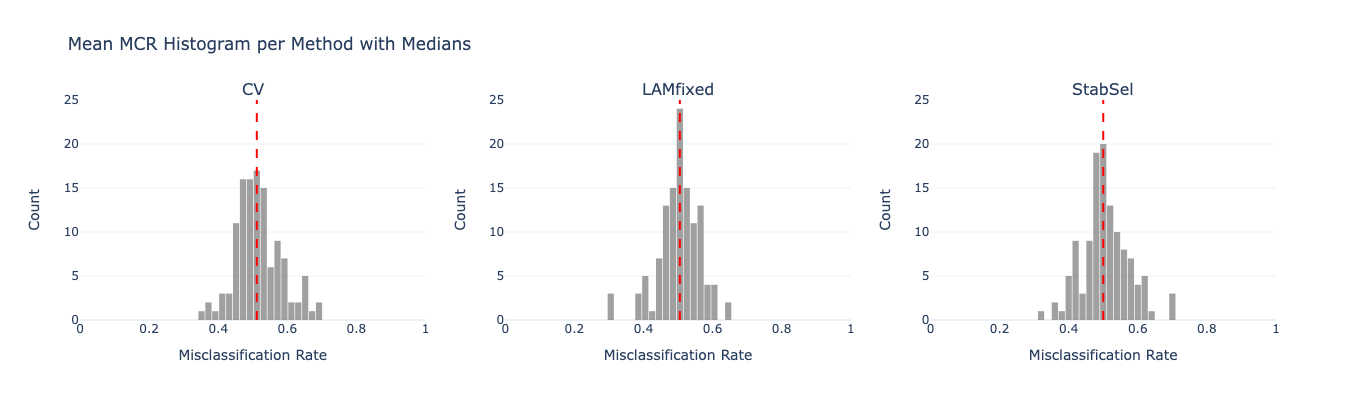

In [56]:
mcr_data = {
    'CV': [],
    'LAMfixed': [],
    'StabSel': []
}
for cluster_vals in avg_mcr_results.values():
    for level_vals in cluster_vals.values():
        mcr_data['CV'].append(level_vals['mean_MCR_CV'])
        mcr_data['LAMfixed'].append(level_vals['mean_MCR_LAMfixed'])
        mcr_data['StabSel'].append(level_vals['mean_MCR_StabSel'])

# Calculate global range for histogram bins
all_values = np.concatenate([mcr_data[m] for m in mcr_data])
x_min, x_max = all_values.min(), all_values.max()
nbins = 20
bin_width = (x_max - x_min) / nbins

# Create histogram subplots
methods = ['CV', 'LAMfixed', 'StabSel']
fig = make_subplots(rows=1, cols=3, subplot_titles=methods)

# Add histograms
for i, method in enumerate(methods):
    median = np.median(mcr_data[method])
    bin_start = median - ((np.floor((median - x_min) / bin_width) + 0.5) * bin_width)
    fig.add_trace(go.Histogram(
        x=mcr_data[method],
        name=method,
        xbins=dict(start=bin_start, end=x_max, size=bin_width),
        marker_color='gray',
        opacity=0.75,
        showlegend=False
    ), row=1, col=i+1)

# Add vertical lines for medians
for i, method in enumerate(methods):
    median_value = np.median(mcr_data[method])
    fig.add_shape(
        type="line",
        x0=median_value, x1=median_value,
        y0=0, y1=1,
        xref=f"x{i+1}",
        yref="paper",
        line=dict(color="red", width=2, dash="dash"),
    )

# Update layout
fig.update_layout(
    title_text="Mean MCR Histogram per Method with Medians",
    height=400,
    width=1000,
    template='plotly_white',
    bargap=0.1
)

# Sync x-axis and label
for i in range(1, 4):
    fig.update_xaxes(title_text="Misclassification Rate", range=[0, 1], row=1, col=i)
    fig.update_yaxes(title_text="Count", range=[0, 25], row=1, col=i)

fig.show()

fig.write_image("plots/png/avg_mcr_histogram.png")
fig.write_image("plots/pdf/avg_mcr_histogram.pdf")
fig.write_image("plots/svg/avg_mcr_histogram.svg")
fig.write_html("plots/html/avg_mcr_histogram.html")

### in-sample

In [46]:
with open(f'data/run_{run}_result_dict_{class_problem}_filt_{threshold}_stabsel_{stabsel_threshold}_{transform}_nlam_{Nlam}.pkl', 'rb') as file:
    result_dict = pkl.load(file)

levels = ["phylum", "class", "order", "family", "genus", "species", "ASVs"]
columns = allergy_status.keys()

mcr_fix_in_sample = pd.DataFrame(index=levels, columns=columns)
mcr_cv_in_sample = pd.DataFrame(index=levels, columns=columns)
mcr_stabsel_in_sample = pd.DataFrame(index=levels, columns=columns)

beta_fix_in_sample = pd.DataFrame(index=levels, columns=columns)
beta_cv_in_sample = pd.DataFrame(index=levels, columns=columns)
beta_stabsel_in_sample = pd.DataFrame(index=levels, columns=columns)

# Fill DataFrames with in-sample results
for cluster in result_dict.keys():
    for level in levels:
        if level in result_dict[cluster]:
            mcr_fix_in_sample.at[level, cluster] = result_dict[cluster][level]['in-sample MCR (LAMfixed)'].round(2)
            mcr_cv_in_sample.at[level, cluster] = result_dict[cluster][level]["in-sample MCR (CV)"].round(2)
            mcr_stabsel_in_sample.at[level, cluster] = result_dict[cluster][level]["in-sample MCR (StabSel)"].round(2)
            
            beta_fix = result_dict[cluster][level]['sol'].LAMfixed.beta
            beta_fix_in_sample.at[level, cluster] = count_nonzero_excl_intercept(beta_fix)

            beta_cv = result_dict[cluster][level]['sol'].CV.beta
            beta_cv_in_sample.at[level, cluster] = count_nonzero_excl_intercept(beta_cv)

            beta_stabsel = result_dict[cluster][level]['sol'].StabSel.refit
            beta_stabsel_in_sample.at[level, cluster] = count_nonzero_excl_intercept(beta_stabsel)

# Combine values into display format: MCR (number of nonzero β)
fix_in_sample_str = mcr_fix_in_sample.astype(str) + " (" + beta_fix_in_sample.astype(str) + ")"
cv_in_sample_str = mcr_cv_in_sample.astype(str) + " (" + beta_cv_in_sample.astype(str) + ")"
stabsel_in_sample_str = mcr_stabsel_in_sample.astype(str) + " (" + beta_stabsel_in_sample.astype(str) + ")"

In [47]:
fix_in_sample_str

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.5 (4),0.51 (3),0.44 (6),0.46 (2),0.48 (5),0.4 (6),0.39 (2),0.42 (5),0.45 (2),0.47 (5),0.29 (4),0.31 (3),0.47 (2),0.41 (7),0.26 (4)
class,0.5 (5),0.49 (5),0.47 (9),0.5 (3),0.48 (5),0.43 (7),0.39 (2),0.39 (7),0.38 (3),0.42 (3),0.32 (6),0.25 (3),0.47 (4),0.39 (7),0.26 (3)
order,0.47 (10),0.39 (4),0.42 (19),0.4 (3),0.45 (8),0.35 (12),0.33 (3),0.37 (6),0.45 (5),0.4 (3),0.41 (4),0.19 (3),0.42 (3),0.31 (7),0.26 (3)
family,0.44 (6),0.35 (4),0.44 (9),0.38 (4),0.34 (13),0.43 (12),0.28 (3),0.39 (5),0.35 (4),0.47 (5),0.35 (5),0.25 (3),0.42 (4),0.3 (9),0.24 (5)
genus,0.4 (9),0.43 (4),0.4 (13),0.4 (3),0.22 (29),0.3 (28),0.28 (2),0.32 (5),0.32 (3),0.39 (6),0.41 (2),0.44 (3),0.42 (7),0.31 (8),0.24 (3)
species,0.35 (19),0.3 (16),0.31 (39),0.22 (14),0.24 (21),0.37 (14),0.22 (6),0.45 (4),0.25 (9),0.18 (24),0.32 (6),0.12 (4),0.22 (32),0.3 (8),0.21 (9)
ASVs,0.3 (44),0.28 (16),0.27 (42),0.22 (16),0.26 (24),0.32 (25),0.28 (4),0.45 (3),0.28 (9),0.07 (26),0.26 (6),0.12 (4),0.25 (35),0.28 (8),0.24 (9)


In [48]:
cv_in_sample_str

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.5 (0),0.5 (2),0.49 (2),0.48 (2),0.43 (7),0.4 (6),0.33 (4),0.37 (7),0.45 (3),0.51 (2),0.32 (6),0.19 (4),0.47 (2),0.41 (7),0.26 (4)
class,0.5 (0),0.5 (2),0.49 (2),0.47 (2),0.45 (2),0.44 (7),0.33 (5),0.5 (0),0.38 (3),0.47 (2),0.29 (7),0.06 (6),0.47 (2),0.34 (7),0.24 (7)
order,0.5 (0),0.41 (3),0.4 (18),0.5 (0),0.47 (3),0.35 (12),0.33 (4),0.21 (19),0.45 (5),0.46 (2),0.32 (2),0.19 (3),0.5 (0),0.33 (7),0.26 (2)
family,0.45 (2),0.35 (3),0.46 (2),0.4 (2),0.33 (21),0.35 (19),0.33 (2),0.18 (10),0.32 (2),0.5 (0),0.32 (3),0.12 (5),0.5 (0),0.3 (14),0.26 (5)
genus,0.45 (4),0.46 (2),0.39 (13),0.39 (2),0.22 (27),0.31 (28),0.0 (13),0.08 (17),0.3 (2),0.24 (20),0.0 (24),0.25 (8),0.22 (28),0.17 (37),0.26 (3)
species,0.44 (3),0.5 (0),0.37 (13),0.16 (31),0.36 (3),0.47 (2),0.22 (6),0.45 (4),0.0 (61),0.03 (37),0.0 (19),0.12 (4),0.07 (59),0.34 (5),0.15 (11)
ASVs,0.34 (22),0.5 (0),0.45 (2),0.04 (37),0.36 (2),0.36 (12),0.06 (10),0.34 (4),0.0 (55),0.0 (64),0.03 (17),0.06 (7),0.1 (56),0.3 (6),0.03 (19)


In [49]:
stabsel_in_sample_str

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.48 (7),0.38 (7),0.49 (7),0.48 (7),0.39 (8),0.36 (7),0.11 (7),0.37 (7),0.38 (7),0.42 (8),0.41 (7),0.19 (7),0.44 (7),0.47 (7),0.15 (7)
class,0.46 (11),0.34 (11),0.46 (10),0.41 (11),0.41 (11),0.35 (11),0.06 (11),0.34 (11),0.22 (11),0.43 (11),0.24 (11),0.12 (8),0.41 (11),0.34 (11),0.15 (10)
order,0.51 (10),0.42 (9),0.44 (10),0.36 (11),0.38 (11),0.35 (12),0.0 (9),0.34 (8),0.32 (10),0.43 (8),0.26 (10),0.12 (7),0.44 (9),0.36 (9),0.12 (9)
family,0.46 (8),0.35 (8),0.39 (9),0.41 (9),0.36 (9),0.44 (8),0.0 (7),0.29 (9),0.25 (9),0.38 (11),0.21 (9),0.19 (6),0.47 (6),0.34 (9),0.09 (9)
genus,0.41 (5),0.38 (7),0.44 (6),0.36 (5),0.32 (7),0.45 (5),0.28 (4),0.21 (6),0.25 (5),0.4 (5),0.29 (7),0.31 (5),0.39 (6),0.27 (6),0.24 (4)
species,0.44 (3),0.47 (5),0.43 (5),0.34 (4),0.36 (4),0.41 (5),0.11 (8),0.24 (4),0.22 (6),0.44 (6),0.38 (3),0.25 (4),0.45 (5),0.41 (2),0.26 (6)
ASVs,0.45 (3),0.36 (6),0.45 (3),0.34 (5),0.36 (3),0.43 (4),0.11 (6),0.24 (4),0.22 (4),0.35 (5),0.29 (4),0.12 (7),0.44 (2),0.36 (5),0.24 (6)


### Pick the best models

In [27]:
with open(f'data/result_dict_{class_problem}_filt_{threshold}_stabsel_{stabsel_threshold}_{transform}_nlam_{Nlam}.pkl', 'rb') as file:
    result_dict = pkl.load(file)

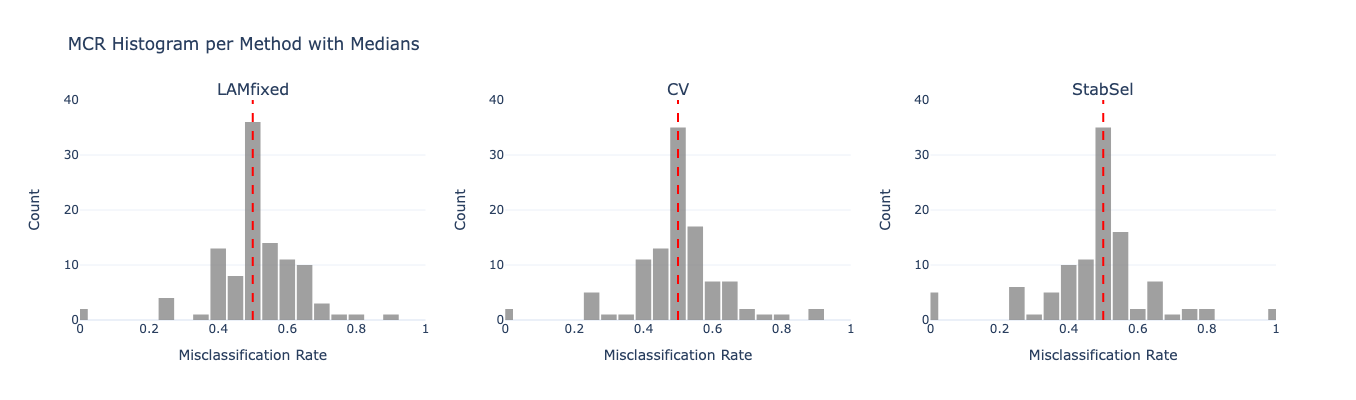

In [31]:
levels = ["phylum", "class", "order", "family", "genus", "species", "ASVs"]
methods = ['LAMfixed', 'CV', 'StabSel']
mcr_data = {method: [] for method in methods}

# Fill in the data
for cluster in allergy_status.keys():
    for lvl in levels:
        for method in methods:
            mcr_value = result_dict[cluster][lvl][f'MCR ({method})']
            mcr_data[method].append(mcr_value)

# Find global x range
all_values = np.concatenate([mcr_data[m] for m in methods])
x_min = all_values.min()
x_max = all_values.max()

# Define bin size
nbins = 20
bin_width = (x_max - x_min) / nbins

# Create subplot layout for histograms
fig = make_subplots(rows=1, cols=3, subplot_titles=methods)

# Add histogram plots to subplots
for i, method in enumerate(methods):
    median = np.median(mcr_data[method])
    # Align bin start so median is at center of a bin
    bin_start = median - ((np.floor((median - x_min) / bin_width) + 0.5) * bin_width)
    
    fig.add_trace(go.Histogram(
        x=mcr_data[method],
        name=method,
        xbins=dict(
            start=bin_start,
            end=x_max,
            size=bin_width
        ),
        marker_color='gray',
        opacity=0.75,
        showlegend=False
    ), row=1, col=i+1)

# Add vertical median lines
for i, method in enumerate(methods):
    median_value = np.median(mcr_data[method])
    fig.add_shape(
        type="line",
        x0=median_value, x1=median_value,
        y0=0, y1=1,  # relative to yref
        xref=f"x{i+1}",  # Important! refer to each subplot's xaxis
        yref=f"paper",  # relative to the entire paper height
        line=dict(color="red", width=2, dash="dash"),
    )

# Layout settings
fig.update_layout(
    title_text="MCR Histogram per Method with Medians",
    height=400,
    width=1000,
    template='plotly_white',
    bargap=0.1
)

# Sync x-axis and add labels
for i in range(1, 4):
    fig.update_xaxes(title_text="Misclassification Rate", range=[0, 1], row=1, col=i)
    fig.update_yaxes(title_text="Count", range=[0, 40], row=1, col=i)

# Show plot
fig.show()

# fig.write_image("plots/png/mcr_histogram.png")
# fig.write_image("plots/pdf/mcr_histogram.pdf")
# fig.write_image("plots/svg/mcr_histogram.svg")
# fig.write_html("plots/html/mcr_histogram.html")

In [18]:
# with open(f'data/result_dict_{class_problem}_filt_{threshold}_stabsel_{stabsel_threshold}_{transform}_nlam_{Nlam}.pkl', 'rb') as file:
with open(f'data/result_dict_{class_problem}_filt_{threshold}_stabsel_{stabsel_threshold}_{transform}_nlam_{Nlam}.pkl', 'rb') as file:
    result_dict = pkl.load(file)


levels = ["phylum", "class", "order", "family", "genus", "species", "ASVs"]
columns = allergy_status.keys()
# columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# columns = ["birch", "grass_pr10", "pr10", "grass_dustmite", "grass_bromelain", "grass", "undefined"]

df_fix = pd.DataFrame(index=levels, columns=columns)
df_cv = pd.DataFrame(index=levels, columns=columns)
df_stabsel = pd.DataFrame(index=levels, columns=columns)

betas_fix = pd.DataFrame(index=levels, columns=columns)
betas_cv = pd.DataFrame(index=levels, columns=columns)
betas_stabsel = pd.DataFrame(index=levels, columns=columns)


for cluster in result_dict.keys():
    for level in levels:
        if level in result_dict[cluster]:
            df_fix.at[level, cluster] = result_dict[cluster][level]['MCR (LAMfixed)'].round(2)
            df_cv.at[level, cluster] = result_dict[cluster][level]["MCR (CV)"].round(2)
            df_stabsel.at[level, cluster] = result_dict[cluster][level]["MCR (StabSel)"].round(2)
            
            beta_fix_n = result_dict[cluster][level]['sol'].LAMfixed.beta
            betas_fix.at[level, cluster] = count_nonzero_excl_intercept(beta_fix_n)

            beta_cv_n = result_dict[cluster][level]['sol'].CV.beta
            betas_cv.at[level, cluster] = count_nonzero_excl_intercept(beta_cv_n)

            beta_stabsel_n = result_dict[cluster][level]['sol'].StabSel.refit
            betas_stabsel.at[level, cluster] = count_nonzero_excl_intercept(beta_stabsel_n)
            
combined_fix = df_fix.astype(str) + " (" + betas_fix.astype(str) + ")"
combined_cv = df_cv.astype(str) + " (" + betas_cv.astype(str) + ")"
combined_stabsel = df_stabsel.astype(str) + " (" + betas_stabsel.astype(str) + ")"

### presprocessing dimensions
# combined_df_prep = df_before.T.astype(str) + " (" + df_after.T.astype(str) + ")"

### out-of-sample

In [19]:
combined_fix

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.49 (4),0.61 (3),0.6 (5),0.5 (2),0.45 (6),0.5 (7),0.25 (4),0.62 (3),0.4 (4),0.56 (3),0.5 (4),0.5 (3),0.5 (3),0.5 (3),0.38 (2)
class,0.48 (5),0.56 (2),0.59 (5),0.5 (4),0.48 (8),0.57 (9),0.25 (4),0.75 (4),0.6 (3),0.62 (4),0.38 (5),0.5 (3),0.57 (5),0.36 (5),0.38 (3)
order,0.51 (6),0.56 (3),0.58 (12),0.5 (4),0.5 (7),0.57 (12),0.25 (3),0.5 (4),0.6 (4),0.62 (5),0.38 (5),0.0 (3),0.57 (9),0.43 (7),0.38 (2)
family,0.44 (3),0.67 (6),0.47 (6),0.55 (4),0.38 (11),0.6 (6),0.5 (5),0.5 (5),0.5 (4),0.69 (8),0.62 (6),0.0 (2),0.61 (8),0.5 (3),0.5 (5)
genus,0.49 (4),0.61 (4),0.45 (10),0.55 (2),0.4 (18),0.6 (7),0.5 (2),0.88 (6),0.8 (5),0.5 (10),0.5 (11),0.5 (3),0.54 (20),0.64 (4),0.62 (4)
species,0.52 (19),0.5 (24),0.41 (24),0.41 (14),0.43 (27),0.55 (11),0.5 (4),0.5 (6),0.5 (11),0.56 (16),0.25 (6),0.5 (4),0.64 (14),0.71 (17),0.62 (7)
ASVs,0.59 (55),0.56 (19),0.53 (56),0.41 (12),0.5 (27),0.52 (18),0.5 (5),0.38 (6),0.4 (12),0.44 (14),0.5 (8),0.5 (3),0.68 (13),0.43 (20),0.62 (9)


In [20]:
combined_cv

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.5 (2),0.61 (2),0.58 (7),0.5 (2),0.64 (2),0.5 (7),0.5 (2),0.62 (3),0.4 (4),0.56 (2),0.38 (6),0.5 (2),0.54 (5),0.57 (5),0.38 (2)
class,0.49 (2),0.56 (2),0.5 (5),0.5 (10),0.5 (0),0.57 (6),0.5 (0),0.5 (3),0.6 (3),0.56 (2),0.38 (4),0.5 (2),0.46 (11),0.43 (9),0.5 (5)
order,0.5 (2),0.56 (2),0.56 (18),0.5 (12),0.55 (2),0.57 (16),0.25 (7),0.88 (8),0.6 (4),0.62 (3),0.38 (20),0.0 (2),0.54 (8),0.57 (24),0.38 (2)
family,0.46 (3),0.56 (2),0.46 (7),0.55 (4),0.5 (0),0.55 (7),0.5 (5),0.5 (5),0.3 (2),0.62 (4),0.5 (23),0.0 (2),0.5 (0),0.5 (3),0.38 (7)
genus,0.49 (3),0.56 (6),0.44 (11),0.45 (9),0.5 (0),0.62 (9),0.25 (7),0.88 (7),0.8 (5),0.56 (10),0.5 (67),0.5 (3),0.46 (15),0.64 (4),0.62 (2)
species,0.5 (13),0.72 (6),0.45 (36),0.23 (25),0.45 (5),0.45 (2),0.25 (15),0.75 (14),0.5 (12),0.38 (43),0.38 (4),0.5 (4),0.61 (9),0.43 (9),0.5 (17)
ASVs,0.52 (25),0.61 (2),0.49 (49),0.36 (16),0.45 (173),0.5 (3),0.25 (17),0.5 (2),0.7 (80),0.44 (17),0.38 (2),0.5 (4),0.64 (6),0.5 (6),0.38 (17)


In [21]:
combined_stabsel

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.49 (7),0.56 (7),0.53 (7),0.55 (7),0.45 (7),0.43 (7),0.0 (7),0.5 (7),0.5 (7),0.62 (7),0.5 (7),0.5 (7),0.46 (7),0.57 (7),0.25 (7)
class,0.46 (10),0.5 (11),0.53 (11),0.41 (10),0.43 (11),0.55 (11),0.0 (11),0.38 (11),0.3 (11),0.5 (11),0.5 (11),0.5 (10),0.5 (11),0.5 (10),0.38 (10)
order,0.52 (10),0.5 (11),0.56 (10),0.5 (10),0.55 (12),0.57 (9),0.25 (9),1.0 (9),0.8 (8),0.56 (10),0.25 (11),0.0 (9),0.64 (9),0.43 (10),0.5 (8)
family,0.5 (8),0.56 (9),0.47 (8),0.55 (9),0.4 (10),0.52 (9),0.25 (8),0.75 (9),0.5 (8),0.69 (7),0.62 (8),0.0 (8),0.5 (9),0.36 (9),0.75 (6)
genus,0.5 (6),0.44 (4),0.51 (4),0.45 (7),0.36 (8),0.55 (5),0.25 (5),1.0 (6),0.8 (7),0.38 (5),0.5 (5),0.5 (5),0.43 (7),0.57 (6),0.5 (3)
species,0.56 (4),0.61 (3),0.4 (3),0.41 (4),0.36 (3),0.52 (5),0.5 (5),0.5 (5),0.5 (3),0.62 (4),0.25 (4),0.5 (4),0.64 (7),0.36 (4),0.38 (8)
ASVs,0.51 (4),0.44 (3),0.5 (4),0.41 (5),0.5 (1),0.55 (6),0.5 (7),0.5 (5),0.5 (5),0.62 (2),0.38 (4),0.0 (7),0.61 (4),0.36 (3),0.62 (7)


### in-sample

In [22]:
with open(f'data/result_dict_{class_problem}_filt_{threshold}_stabsel_{stabsel_threshold}_{transform}_nlam_{Nlam}.pkl', 'rb') as file:
    result_dict = pkl.load(file)


levels = ["phylum", "class", "order", "family", "genus", "species", "ASVs"]
columns = allergy_status.keys()

mcr_fix_in_sample = pd.DataFrame(index=levels, columns=columns)
mcr_cv_in_sample = pd.DataFrame(index=levels, columns=columns)
mcr_stabsel_in_sample = pd.DataFrame(index=levels, columns=columns)

beta_fix_in_sample = pd.DataFrame(index=levels, columns=columns)
beta_cv_in_sample = pd.DataFrame(index=levels, columns=columns)
beta_stabsel_in_sample = pd.DataFrame(index=levels, columns=columns)

# Fill DataFrames with in-sample results
for cluster in result_dict.keys():
    for level in levels:
        if level in result_dict[cluster]:
            mcr_fix_in_sample.at[level, cluster] = result_dict[cluster][level]['in-sample MCR (LAMfixed)'].round(2)
            mcr_cv_in_sample.at[level, cluster] = result_dict[cluster][level]["in-sample MCR (CV)"].round(2)
            mcr_stabsel_in_sample.at[level, cluster] = result_dict[cluster][level]["in-sample MCR (StabSel)"].round(2)
            
            beta_fix = result_dict[cluster][level]['sol'].LAMfixed.beta
            beta_fix_in_sample.at[level, cluster] = count_nonzero_excl_intercept(beta_fix)

            beta_cv = result_dict[cluster][level]['sol'].CV.beta
            beta_cv_in_sample.at[level, cluster] = count_nonzero_excl_intercept(beta_cv)

            beta_stabsel = result_dict[cluster][level]['sol'].StabSel.refit
            beta_stabsel_in_sample.at[level, cluster] = count_nonzero_excl_intercept(beta_stabsel)

# Combine values into display format: MCR (number of nonzero β)
fix_in_sample_str = mcr_fix_in_sample.astype(str) + " (" + beta_fix_in_sample.astype(str) + ")"
cv_in_sample_str = mcr_cv_in_sample.astype(str) + " (" + beta_cv_in_sample.astype(str) + ")"
stabsel_in_sample_str = mcr_stabsel_in_sample.astype(str) + " (" + beta_stabsel_in_sample.astype(str) + ")"

In [23]:
fix_in_sample_str

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.48 (4),0.41 (3),0.48 (5),0.48 (2),0.48 (6),0.45 (7),0.44 (4),0.39 (3),0.4 (4),0.44 (3),0.35 (4),0.38 (3),0.43 (3),0.44 (3),0.35 (2)
class,0.46 (5),0.42 (2),0.46 (5),0.43 (4),0.45 (8),0.37 (9),0.44 (4),0.34 (4),0.45 (3),0.4 (4),0.35 (5),0.31 (3),0.46 (5),0.41 (5),0.32 (3)
order,0.45 (6),0.43 (3),0.41 (12),0.38 (4),0.44 (7),0.4 (12),0.33 (3),0.42 (4),0.32 (4),0.36 (5),0.38 (5),0.25 (3),0.42 (9),0.31 (7),0.29 (2)
family,0.46 (3),0.38 (6),0.42 (6),0.38 (4),0.41 (11),0.36 (6),0.17 (5),0.37 (5),0.42 (4),0.4 (8),0.24 (6),0.31 (2),0.46 (8),0.41 (3),0.32 (5)
genus,0.45 (4),0.35 (4),0.39 (10),0.37 (2),0.26 (18),0.39 (7),0.33 (2),0.26 (6),0.28 (5),0.38 (10),0.21 (11),0.38 (3),0.26 (20),0.44 (4),0.35 (4)
species,0.37 (19),0.26 (24),0.38 (24),0.28 (14),0.27 (27),0.33 (11),0.22 (4),0.34 (6),0.22 (11),0.25 (16),0.32 (6),0.19 (4),0.34 (14),0.19 (17),0.32 (7)
ASVs,0.3 (55),0.28 (19),0.28 (56),0.28 (12),0.29 (27),0.32 (18),0.22 (5),0.26 (6),0.18 (12),0.25 (14),0.29 (8),0.19 (3),0.3 (13),0.23 (20),0.35 (9)


In [24]:
cv_in_sample_str

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.48 (2),0.39 (2),0.46 (7),0.48 (2),0.5 (2),0.38 (7),0.39 (2),0.42 (3),0.4 (4),0.49 (2),0.29 (6),0.44 (2),0.42 (5),0.42 (5),0.38 (2)
class,0.46 (2),0.42 (2),0.47 (5),0.38 (10),0.5 (0),0.43 (6),0.5 (0),0.39 (3),0.45 (3),0.46 (2),0.38 (4),0.38 (2),0.39 (11),0.38 (9),0.26 (5)
order,0.47 (2),0.46 (2),0.39 (18),0.33 (12),0.45 (2),0.37 (16),0.11 (7),0.26 (8),0.38 (4),0.44 (3),0.18 (20),0.31 (2),0.43 (8),0.23 (24),0.29 (2)
family,0.46 (3),0.42 (2),0.43 (7),0.39 (4),0.5 (0),0.37 (7),0.22 (5),0.37 (5),0.4 (2),0.43 (4),0.0 (23),0.31 (2),0.5 (0),0.41 (3),0.29 (7)
genus,0.45 (3),0.31 (6),0.4 (11),0.31 (9),0.5 (0),0.38 (9),0.11 (7),0.21 (7),0.25 (5),0.32 (10),0.0 (67),0.38 (3),0.28 (15),0.5 (4),0.35 (2)
species,0.37 (13),0.43 (6),0.33 (36),0.21 (25),0.39 (5),0.43 (2),0.06 (15),0.03 (14),0.22 (12),0.04 (43),0.38 (4),0.19 (4),0.35 (9),0.25 (9),0.09 (17)
ASVs,0.33 (25),0.45 (2),0.3 (49),0.22 (16),0.01 (173),0.42 (3),0.06 (17),0.34 (2),0.0 (80),0.21 (17),0.35 (2),0.19 (4),0.33 (6),0.34 (6),0.06 (17)


In [25]:
stabsel_in_sample_str

,any_ige,single,multiple,high_score,medium_score,low_score,A,B,C,D,E,F,I,H,G
phylum,0.46 (7),0.39 (7),0.44 (7),0.47 (7),0.47 (7),0.38 (7),0.28 (7),0.37 (7),0.3 (7),0.38 (7),0.35 (7),0.19 (7),0.42 (7),0.36 (7),0.32 (7)
class,0.48 (10),0.31 (11),0.45 (11),0.39 (10),0.42 (11),0.36 (11),0.17 (11),0.29 (11),0.28 (11),0.38 (11),0.21 (11),0.12 (10),0.36 (11),0.31 (10),0.15 (10)
order,0.44 (10),0.34 (11),0.4 (10),0.37 (10),0.43 (12),0.4 (9),0.11 (9),0.26 (9),0.38 (8),0.39 (10),0.29 (11),0.31 (9),0.38 (9),0.33 (10),0.32 (8)
family,0.45 (8),0.38 (9),0.43 (8),0.36 (9),0.39 (10),0.38 (9),0.17 (8),0.21 (9),0.32 (8),0.43 (7),0.21 (8),0.06 (8),0.46 (9),0.36 (9),0.32 (6)
genus,0.4 (6),0.39 (4),0.44 (4),0.32 (7),0.39 (8),0.38 (5),0.33 (5),0.26 (6),0.2 (7),0.43 (5),0.38 (5),0.25 (5),0.42 (7),0.28 (6),0.29 (3)
species,0.4 (4),0.42 (3),0.46 (3),0.33 (4),0.43 (3),0.38 (5),0.17 (5),0.29 (5),0.45 (3),0.5 (4),0.35 (4),0.25 (4),0.37 (7),0.34 (4),0.21 (8)
ASVs,0.44 (4),0.49 (3),0.43 (4),0.38 (5),0.43 (1),0.35 (6),0.33 (7),0.24 (5),0.38 (5),0.36 (2),0.35 (4),0.19 (7),0.36 (4),0.36 (3),0.18 (7)


In [26]:
with open('data/taxa_dict_ige.pickle', 'rb') as file:
    taxa_dict = pkl.load(file)

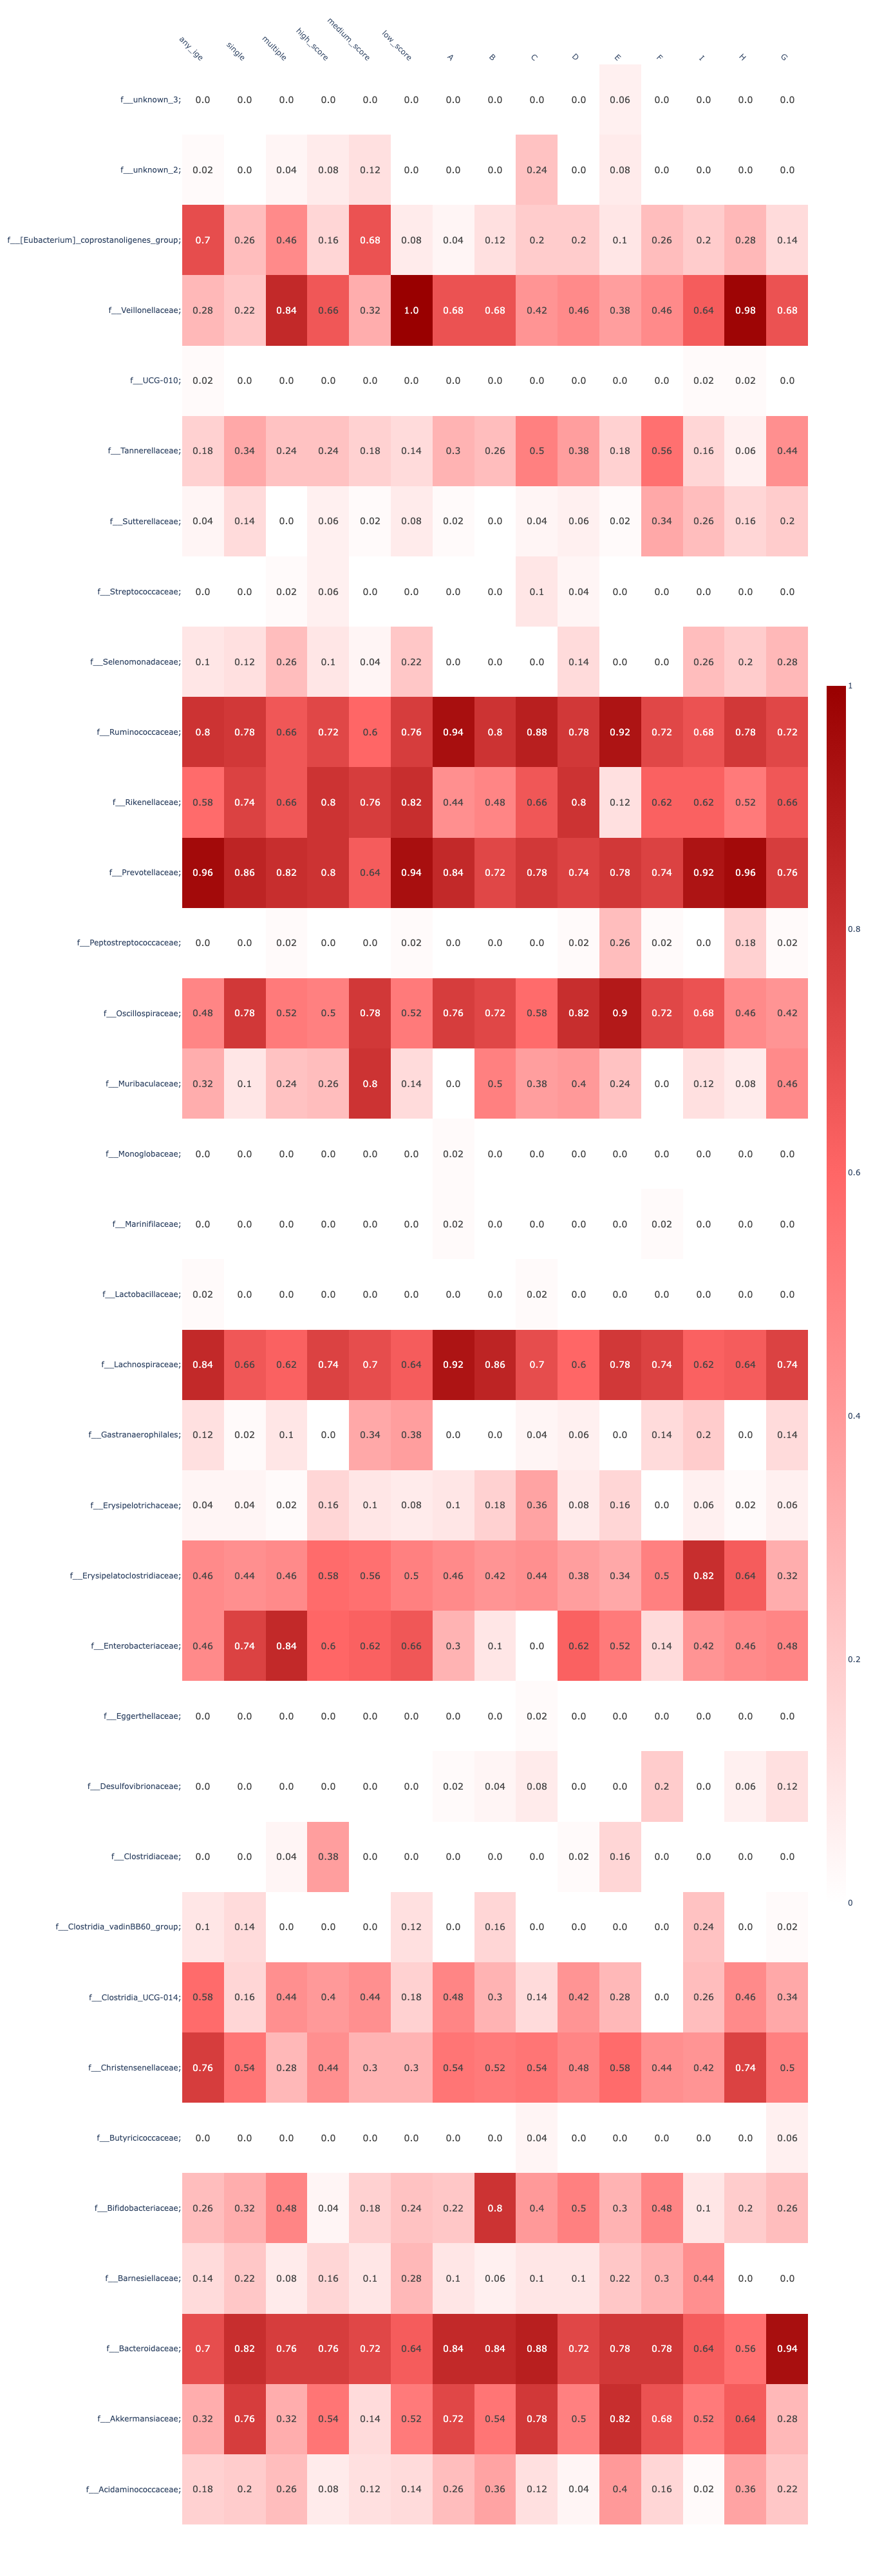

In [30]:
lvl = "family"

# Sort the taxa_dict by index (i.e., family names)
sorted_family_names = taxa_dict['family'].sort_index()

vis_df = pd.DataFrame()

for cluster in allergy_status.keys():
    sol = result_dict[cluster][lvl]['sol']
    
    all_families = sol.StabSel.label
    distribution_families = sol.StabSel.distribution

    # Create a DataFrame for this cluster
    cluster_df = pd.DataFrame({cluster: distribution_families}, index=all_families)
    
    # Combine with overall DataFrame
    vis_df = pd.concat([vis_df, cluster_df], axis=1)

vis_df = vis_df.fillna(0) 
vis_df = vis_df.iloc[1:, ] ### exclude intercept
vis_df = vis_df.loc[(vis_df != 0).any(axis=1)] ### drop families that never been selected


# Create text labels and conditional text color matrix
text_vals = vis_df.round(2).astype(str).values
text_colors = np.where(vis_df.values > 0.5, 'white', '#2A3F5F')

# Create the heatmap using go.Heatmap
fig = go.Figure(data=go.Heatmap(
    z=vis_df.values,
    x=vis_df.columns,
    y=vis_df.index,
    text=text_vals,
    texttemplate="%{text}",
    textfont={"size": 14},
    colorscale=[
        [0.0, "#ffffff"],
        [0.2, "#ffcccc"],
        [0.6, "#ff6666"],
        [1.0, "#990000"]
    ],
    colorbar=dict(len=0.5),
    showscale=True,
    hoverinfo='text',
))

fig.update_layout(
    width=1000,
    height=4000,
    plot_bgcolor='white'
)
fig.update_xaxes(side='top', tickangle=45)

fig.show()